In [1]:
from keras.utils import to_categorical
from keras.optimizers import Adam, Adadelta, SGD
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Dropout, Flatten, Conv1D, GlobalAveragePooling1D, Convolution1D
from keras.layers.convolutional import MaxPooling2D, MaxPooling1D
from keras.models import load_model
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.utils import class_weight
from scipy import signal
from glob import glob
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

c:\users\sebastiaan\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# constants:
SUBSAMPLE = 10  # scales the data by this factor
COLUMNS = ['HandStart', 'FirstDigitTouch',
        'BothStartLoadPhase', 'LiftOff',
        'Replace', 'BothReleased']
TRAIN_SUBJECTS = range(1, 9)
TEST_SUBJECTS = range(9, 13)
N_LABELS = 6

# Below are the paths to the data. Please pay attention to the % and * signs, these are needed in the loop.
TRAIN_DATA_PATH = 'C:/Users/Sebastiaan/Desktop/Programming/MachineLearning/Datasets/EEG/train/subj%d_series*_data.csv'
# TRAIN_DATA_PATH = 'C:/Users/bas/Documents/MachineLearning/train/subj%d_series*_data.csv'

EPOCHS = 100
WINDOW_SIZE = 2000
SPLIT_SIZE = 50
BATCH_SIZE = 10

In [3]:
def prepare_training_data(data_path):
    data = pd.read_csv(data_path)
    event_path = data_path.replace('_data', '_events')
    labels = pd.read_csv(event_path)
    clean_data = data.drop(['id'], axis = 1)
    labels = labels.drop(['id'], axis = 1)
    return clean_data, labels

In [4]:
def preprocess_data(x_raw, WINDOW_SIZE, subsample):
    x_raw, scaler = scaler_transform(x_raw[::subsample], None)
    x_raw = image_mappping(x_raw, WINDOW_SIZE)
    return x_raw, scaler

In [5]:
def scaler_transform(data, scaler):
    if scaler == None:
        scaler = Normalizer()
        return scaler.fit_transform(data), scaler
    else:
        return scaler.transform(data)   

In [6]:
def read_training_data(train_data_paths):
    labels_raw = []
    features_raw = []
    for data_path in train_data_paths:
        data, labels = prepare_training_data(data_path)
        features_raw.append(data)
        labels_raw.append(labels)
    features_raw = pd.concat(features_raw)
    labels_raw = pd.concat(labels_raw)
    x_train = np.asarray(features_raw.astype(float))
    y_train = np.asarray(labels_raw.astype(float))
    return x_train, y_train

In [7]:
def metric_auc_score(predictions, y_test, with_plot):
    scores = []
    legend_text = []
    for i in range(N_LABELS):
        fpr, tpr, _  = roc_curve(y_test[:,i], predictions[:,i], 1)
        scores.append(roc_auc_score(y_test[:,i], predictions[:,i]))
        legend_text.append(COLUMNS[i]+' (area = %.3f)' % (scores[i]))
        if with_plot == True:
            plt.plot(fpr, tpr)
    if with_plot == True:
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.legend(legend_text)
        plt.show()
    return scores

In [8]:
def multiple_metric_auc_score(prediction_total, test_data_total, with_plot):
    legend_text = []
    counter = 0
    for i in range(len(prediction_total)):
        fpr, tpr, _  = roc_curve(test_data_total[i], prediction_total[i], pos_label=1)
        score = roc_auc_score(test_data_total[i],prediction_total[i])
        legend_text.append(COLUMNS[i]+' (area = %.3f)' % (score))
        print(COLUMNS[i]+' AUC score = %.3f' % (score))
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.legend(legend_text)
    plt.show()

In [9]:
def single_metric_auc_score(predictions, y_test, with_plot, i):
    fpr, tpr, _  = roc_curve(y_test, predictions, 1)
    score = roc_auc_score(y_test, predictions)
    print(COLUMNS[i]+' AUC score = %.3f' % (score))
    if with_plot == True:
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.show()
    return score

In [10]:
def all_auc_scores(prediction_total, test_data_total, subjects, with_plot):
    scores = []
    for subject in subjects:
        score = metric_auc_score(prediction_total[subject-1],
                                 test_data_total[subject-1], with_plot)
        scores.append(score)
        print('Mean AUC Score of Subject %d: %.3f' % \
              (subject, np.mean(score)))
    return scores

In [11]:
def image_mappping(x_train, WINDOW_SIZE):
    result = []
    empty_matrix = np.zeros(np.shape(x_train[0:WINDOW_SIZE]))
    for i in range(len(x_train)):
        if i-WINDOW_SIZE < 0:
            result.append(empty_matrix)
        else:
            result.append(x_train[i-WINDOW_SIZE:i])
    return result

In [12]:
def resample_and_shuffle(labels):
    when_task = np.where(labels == 1)
    when_no_task = np.where(labels == 0)
    when_no_task = when_no_task[0][0:len(when_task[0])]
    indices = np.concatenate([when_task[0], when_no_task])
    np.random.shuffle(indices)
    return indices

In [13]:
def balance_set(indices, x_train, y_train):
    balance_x = []
    balance_y = []
    for index in indices:
        balance_x.append(x_train[index])
        balance_y.append(y_train[index])
    return np.array(balance_x), np.array(balance_y)

In [14]:
def remove_imbalance(x_train, y_train):
    indices = resample_and_shuffle(y_train)
    balanced_x_train, balanced_y_train = balance_set(indices, x_train, y_train)
    return balanced_x_train, balanced_y_train

In [15]:
def predict_on_sub(x_test, model, split_size, batch_size):
    split_size = int(len(x_test) / split_size)
    sub_x_test = x_test[1000::batch_size]
    batch = []
    predictions = np.array([])
    for i in range(len(sub_x_test)):
        batch.append(sub_x_test[i])
        if i+1 == len(sub_x_test):
            return np.concatenate([predictions, model.predict(np.array(batch))[:,1]])
        elif (i+1) % split_size == 0:
            predictions = np.concatenate([predictions, model.predict(np.array(batch))[:,1]])
            batch = []

In [16]:
def init_cnn(window):
    model = Sequential()
    model.add(Conv1D(nb_filter=16, filter_length=3, activation='relu', input_shape=(window, 32)))
    model.add(MaxPooling1D(3,2))
    model.add(Conv1D(nb_filter=32, filter_length=3, activation='relu'))
    model.add(Conv1D(nb_filter=64, filter_length=3, activation='relu'))
    model.add(MaxPooling1D(3,2))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, activation='softmax'))
#     model.summary()
    
    optimizer = SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)
#     optimizer = Adam(lr=1e-6)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [17]:
prediction_total = []
test_data_total = []

models = []
for i in range(N_LABELS):
    models.append(init_cnn(WINDOW_SIZE))

for subject in TRAIN_SUBJECTS:
    test_features_raw = []
    train_data_paths = glob(TRAIN_DATA_PATH % (subject))

    
    x_raw, y_raw = read_training_data(train_data_paths)
    
    x_raw, _ = preprocess_data(x_raw, WINDOW_SIZE, SUBSAMPLE)
#     y_train = y_raw[::SUBSAMPLE]
    x_train, _, y_train, _ = train_test_split(x_raw, y_raw[::SUBSAMPLE], test_size=0.5)

    
    for i in range(N_LABELS):
        model = models[i]
        
        balanced_x_train, balanced_y_train = remove_imbalance(x_train, y_train[:,i])
        
        train_labels = to_categorical(balanced_y_train, num_classes = None)
                
        print('Train subject %d, class %s' % (subject, COLUMNS[i]))        
        model.fit(balanced_x_train, train_labels, verbose=1, validation_split=0.2, epochs=EPOCHS)
    
    
    for task_name, model in zip(COLUMNS, models):
        model.save('general_model_'+task_name+'_subject_%d.h5' % (subject))  # creates a HDF5 file 'my_model.h5'
#         predictions = predict_on_sub(x_test, model, SPLIT_SIZE, BATCH_SIZE)
        
#         test_data_total.append(y_test[:,i][1000::BATCH_SIZE])
#         prediction_total.append(predictions)
        
#     multiple_metric_auc_score(prediction_total, test_data_total, True)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
Train subject 1, class HandStart
Train on 3075 samples, validate on 769 samples
Epoch 1/100
3075/3075 [==============================] - 10s 3ms/step - loss: 0.6956 - acc: 0.4966 - val_loss: 0.6927 - val_acc: 0.5189
Epoch 2/100
3075/3075 [==============================] - 5s 2ms/step - loss: 0.6937 - acc: 0.5037 - val_loss: 0.6916 - val_acc: 0.5033
Epoch 3/100
3075/3075 [==============================] - 5s 2ms/step - loss: 0.6920 - acc: 0.5154 - val_loss: 0.6899 - val_acc: 0.5371
Epoch 4/100
3075/3075 [==============================] - 5s 2ms/step - loss: 0.6909 - acc: 0.5207 - val_loss: 0.6885 - val_acc: 0.5280
Epoch 5/100
3075/3075 [==============================] - 5s 2ms/step - loss: 0.6892 - acc: 0.5499 - val_loss: 0.6865 - val_acc: 0.5878
Epoch 6/100
3075/3075 [==============================] - 5s 2ms/step - loss: 0.6858 - acc: 0.5662 - val_loss: 0.6851 - val_acc: 0.5488
Epoch 7/100
3075/3075 [===

3075/3075 [==============================] - 5s 2ms/step - loss: 0.4118 - acc: 0.8237 - val_loss: 0.3898 - val_acc: 0.8427
Epoch 59/100
3075/3075 [==============================] - 5s 2ms/step - loss: 0.4106 - acc: 0.8267 - val_loss: 0.3992 - val_acc: 0.8244
Epoch 60/100
3075/3075 [==============================] - 5s 2ms/step - loss: 0.4170 - acc: 0.8263 - val_loss: 0.3868 - val_acc: 0.8401
Epoch 61/100
3075/3075 [==============================] - 5s 2ms/step - loss: 0.4109 - acc: 0.8250 - val_loss: 0.4057 - val_acc: 0.8218
Epoch 62/100
3075/3075 [==============================] - 5s 2ms/step - loss: 0.4091 - acc: 0.8237 - val_loss: 0.3833 - val_acc: 0.8414
Epoch 63/100
3075/3075 [==============================] - 5s 2ms/step - loss: 0.4002 - acc: 0.8280 - val_loss: 0.3795 - val_acc: 0.8440
Epoch 64/100
3075/3075 [==============================] - 5s 2ms/step - loss: 0.4008 - acc: 0.8286 - val_loss: 0.3768 - val_acc: 0.8518
Epoch 65/100
3075/3075 [==============================] - 5s 

3104/3104 [==============================] - 5s 2ms/step - loss: 0.6837 - acc: 0.5915 - val_loss: 0.6792 - val_acc: 0.5941
Epoch 18/100
3104/3104 [==============================] - 5s 2ms/step - loss: 0.6790 - acc: 0.6128 - val_loss: 0.6764 - val_acc: 0.6572
Epoch 19/100
3104/3104 [==============================] - 5s 2ms/step - loss: 0.6782 - acc: 0.6266 - val_loss: 0.6737 - val_acc: 0.6985
Epoch 20/100
3104/3104 [==============================] - 5s 2ms/step - loss: 0.6771 - acc: 0.6134 - val_loss: 0.6723 - val_acc: 0.6675
Epoch 21/100
3104/3104 [==============================] - 5s 2ms/step - loss: 0.6743 - acc: 0.6263 - val_loss: 0.6692 - val_acc: 0.6804
Epoch 22/100
3104/3104 [==============================] - 5s 2ms/step - loss: 0.6712 - acc: 0.6398 - val_loss: 0.6664 - val_acc: 0.6817
Epoch 23/100
3104/3104 [==============================] - 5s 2ms/step - loss: 0.6697 - acc: 0.6569 - val_loss: 0.6638 - val_acc: 0.6778
Epoch 24/100
3104/3104 [==============================] - 5s 

3104/3104 [==============================] - 5s 2ms/step - loss: 0.2924 - acc: 0.8843 - val_loss: 0.3196 - val_acc: 0.8686
Epoch 78/100
3104/3104 [==============================] - 5s 2ms/step - loss: 0.2835 - acc: 0.8805 - val_loss: 0.3592 - val_acc: 0.8608
Epoch 79/100
3104/3104 [==============================] - 5s 2ms/step - loss: 0.2862 - acc: 0.8879 - val_loss: 0.3344 - val_acc: 0.8698
Epoch 80/100
3104/3104 [==============================] - 5s 2ms/step - loss: 0.2738 - acc: 0.8918 - val_loss: 0.3211 - val_acc: 0.8750
Epoch 81/100
3104/3104 [==============================] - 5s 2ms/step - loss: 0.2722 - acc: 0.8898 - val_loss: 0.3310 - val_acc: 0.8737
Epoch 82/100
3104/3104 [==============================] - 5s 2ms/step - loss: 0.2711 - acc: 0.8918 - val_loss: 0.3528 - val_acc: 0.8570
Epoch 83/100
3104/3104 [==============================] - 5s 2ms/step - loss: 0.2726 - acc: 0.8898 - val_loss: 0.3315 - val_acc: 0.8711
Epoch 84/100
3104/3104 [==============================] - 5s 

3097/3097 [==============================] - 5s 2ms/step - loss: 0.5410 - acc: 0.7359 - val_loss: 0.5472 - val_acc: 0.7652
Epoch 37/100
3097/3097 [==============================] - 5s 2ms/step - loss: 0.5221 - acc: 0.7614 - val_loss: 0.5485 - val_acc: 0.7394
Epoch 38/100
3097/3097 [==============================] - 5s 2ms/step - loss: 0.5150 - acc: 0.7614 - val_loss: 0.5173 - val_acc: 0.7871
Epoch 39/100
3097/3097 [==============================] - 5s 2ms/step - loss: 0.5041 - acc: 0.7707 - val_loss: 0.5052 - val_acc: 0.7871
Epoch 40/100
3097/3097 [==============================] - 5s 2ms/step - loss: 0.4877 - acc: 0.7791 - val_loss: 0.4911 - val_acc: 0.7961
Epoch 41/100
3097/3097 [==============================] - 5s 2ms/step - loss: 0.4745 - acc: 0.7814 - val_loss: 0.4802 - val_acc: 0.7974
Epoch 42/100
3097/3097 [==============================] - 5s 2ms/step - loss: 0.4658 - acc: 0.7908 - val_loss: 0.4903 - val_acc: 0.7897
Epoch 43/100
3097/3097 [==============================] - 5s 

3097/3097 [==============================] - 5s 2ms/step - loss: 0.2124 - acc: 0.9222 - val_loss: 0.2431 - val_acc: 0.8981
Epoch 97/100
3097/3097 [==============================] - 5s 2ms/step - loss: 0.2069 - acc: 0.9219 - val_loss: 0.2475 - val_acc: 0.8981
Epoch 98/100
3097/3097 [==============================] - 5s 2ms/step - loss: 0.2052 - acc: 0.9299 - val_loss: 0.2286 - val_acc: 0.9123
Epoch 99/100
3097/3097 [==============================] - 5s 2ms/step - loss: 0.2064 - acc: 0.9206 - val_loss: 0.2048 - val_acc: 0.9277
Epoch 100/100
3097/3097 [==============================] - 5s 2ms/step - loss: 0.1992 - acc: 0.9238 - val_loss: 0.2703 - val_acc: 0.8955
Train subject 1, class LiftOff
Train on 3112 samples, validate on 778 samples
Epoch 1/100
3112/3112 [==============================] - 6s 2ms/step - loss: 0.6966 - acc: 0.4978 - val_loss: 0.6928 - val_acc: 0.5000
Epoch 2/100
3112/3112 [==============================] - 5s 1ms/step - loss: 0.6942 - acc: 0.5122 - val_loss: 0.6906 - 

Epoch 56/100
3112/3112 [==============================] - 5s 2ms/step - loss: 0.2750 - acc: 0.8933 - val_loss: 0.3006 - val_acc: 0.8715
Epoch 57/100
3112/3112 [==============================] - 5s 2ms/step - loss: 0.2778 - acc: 0.8930 - val_loss: 0.3102 - val_acc: 0.8779
Epoch 58/100
3112/3112 [==============================] - 5s 2ms/step - loss: 0.2756 - acc: 0.8856 - val_loss: 0.2811 - val_acc: 0.8882
Epoch 59/100
3112/3112 [==============================] - 5s 2ms/step - loss: 0.2725 - acc: 0.8927 - val_loss: 0.3213 - val_acc: 0.8702
Epoch 60/100
3112/3112 [==============================] - 5s 2ms/step - loss: 0.2682 - acc: 0.8949 - val_loss: 0.3204 - val_acc: 0.8740
Epoch 61/100
3112/3112 [==============================] - 5s 2ms/step - loss: 0.2704 - acc: 0.8962 - val_loss: 0.2711 - val_acc: 0.8907
Epoch 62/100
3112/3112 [==============================] - 5s 2ms/step - loss: 0.2646 - acc: 0.8956 - val_loss: 0.3160 - val_acc: 0.8728
Epoch 63/100
3112/3112 [========================

Epoch 16/100
3076/3076 [==============================] - 5s 2ms/step - loss: 0.6374 - acc: 0.6886 - val_loss: 0.6290 - val_acc: 0.7377
Epoch 17/100
3076/3076 [==============================] - 5s 2ms/step - loss: 0.6279 - acc: 0.7003 - val_loss: 0.6172 - val_acc: 0.7429
Epoch 18/100
3076/3076 [==============================] - 5s 2ms/step - loss: 0.6145 - acc: 0.7162 - val_loss: 0.6065 - val_acc: 0.7416
Epoch 19/100
3076/3076 [==============================] - 5s 2ms/step - loss: 0.6028 - acc: 0.7259 - val_loss: 0.5917 - val_acc: 0.7571
Epoch 20/100
3076/3076 [==============================] - 5s 2ms/step - loss: 0.5931 - acc: 0.7191 - val_loss: 0.5814 - val_acc: 0.7390
Epoch 21/100
3076/3076 [==============================] - 5s 2ms/step - loss: 0.5804 - acc: 0.7253 - val_loss: 0.5642 - val_acc: 0.7740
Epoch 22/100
3076/3076 [==============================] - 5s 2ms/step - loss: 0.5621 - acc: 0.7367 - val_loss: 0.5504 - val_acc: 0.7740
Epoch 23/100
3076/3076 [========================

3076/3076 [==============================] - 5s 2ms/step - loss: 0.2068 - acc: 0.9223 - val_loss: 0.1873 - val_acc: 0.9182
Epoch 77/100
3076/3076 [==============================] - 5s 2ms/step - loss: 0.2028 - acc: 0.9246 - val_loss: 0.1868 - val_acc: 0.9260
Epoch 78/100
3076/3076 [==============================] - 5s 2ms/step - loss: 0.2035 - acc: 0.9213 - val_loss: 0.2382 - val_acc: 0.9156
Epoch 79/100
3076/3076 [==============================] - 5s 2ms/step - loss: 0.2018 - acc: 0.9246 - val_loss: 0.1802 - val_acc: 0.9260
Epoch 80/100
3076/3076 [==============================] - 5s 2ms/step - loss: 0.2055 - acc: 0.9184 - val_loss: 0.1892 - val_acc: 0.9208
Epoch 81/100
3076/3076 [==============================] - 5s 2ms/step - loss: 0.1932 - acc: 0.9278 - val_loss: 0.1860 - val_acc: 0.9221
Epoch 82/100
3076/3076 [==============================] - 5s 2ms/step - loss: 0.1952 - acc: 0.9308 - val_loss: 0.2055 - val_acc: 0.9234
Epoch 83/100
3076/3076 [==============================] - 5s 

3092/3092 [==============================] - 5s 2ms/step - loss: 0.3693 - acc: 0.8364 - val_loss: 0.3962 - val_acc: 0.8398
Epoch 36/100
3092/3092 [==============================] - 5s 2ms/step - loss: 0.3666 - acc: 0.8438 - val_loss: 0.3808 - val_acc: 0.8372
Epoch 37/100
3092/3092 [==============================] - 5s 2ms/step - loss: 0.3542 - acc: 0.8503 - val_loss: 0.3809 - val_acc: 0.8398
Epoch 38/100
3092/3092 [==============================] - 5s 2ms/step - loss: 0.3528 - acc: 0.8509 - val_loss: 0.3709 - val_acc: 0.8437
Epoch 39/100
3092/3092 [==============================] - 5s 2ms/step - loss: 0.3538 - acc: 0.8506 - val_loss: 0.3661 - val_acc: 0.8437
Epoch 40/100
3092/3092 [==============================] - 5s 2ms/step - loss: 0.3450 - acc: 0.8567 - val_loss: 0.3652 - val_acc: 0.8450
Epoch 41/100
3092/3092 [==============================] - 5s 2ms/step - loss: 0.3403 - acc: 0.8603 - val_loss: 0.3558 - val_acc: 0.8540
Epoch 42/100
3092/3092 [==============================] - 5s 

3092/3092 [==============================] - 5s 2ms/step - loss: 0.1931 - acc: 0.9227 - val_loss: 0.2217 - val_acc: 0.9212
Epoch 96/100
3092/3092 [==============================] - 5s 2ms/step - loss: 0.1924 - acc: 0.9285 - val_loss: 0.2254 - val_acc: 0.9238
Epoch 97/100
3092/3092 [==============================] - 5s 2ms/step - loss: 0.1969 - acc: 0.9240 - val_loss: 0.2254 - val_acc: 0.9238
Epoch 98/100
3092/3092 [==============================] - 5s 2ms/step - loss: 0.1911 - acc: 0.9266 - val_loss: 0.2266 - val_acc: 0.9276
Epoch 99/100
3092/3092 [==============================] - 5s 2ms/step - loss: 0.1970 - acc: 0.9227 - val_loss: 0.2276 - val_acc: 0.9264
Epoch 100/100
3092/3092 [==============================] - 5s 2ms/step - loss: 0.1936 - acc: 0.9253 - val_loss: 0.2267 - val_acc: 0.9264
Train subject 2, class HandStart
Train on 3084 samples, validate on 772 samples
Epoch 1/100
3084/3084 [==============================] - 6s 2ms/step - loss: 0.7469 - acc: 0.5966 - val_loss: 0.6612

Epoch 55/100
3084/3084 [==============================] - 5s 2ms/step - loss: 0.4238 - acc: 0.8129 - val_loss: 0.4173 - val_acc: 0.8199
Epoch 56/100
3084/3084 [==============================] - 5s 2ms/step - loss: 0.4221 - acc: 0.8042 - val_loss: 0.4132 - val_acc: 0.8303
Epoch 57/100
3084/3084 [==============================] - 5s 2ms/step - loss: 0.4132 - acc: 0.8126 - val_loss: 0.4110 - val_acc: 0.8277
Epoch 58/100
3084/3084 [==============================] - 5s 2ms/step - loss: 0.4130 - acc: 0.8132 - val_loss: 0.4130 - val_acc: 0.8212
Epoch 59/100
3084/3084 [==============================] - 5s 2ms/step - loss: 0.4117 - acc: 0.8090 - val_loss: 0.4055 - val_acc: 0.8290
Epoch 60/100
3084/3084 [==============================] - 5s 2ms/step - loss: 0.4054 - acc: 0.8239 - val_loss: 0.4040 - val_acc: 0.8290
Epoch 61/100
3084/3084 [==============================] - 5s 2ms/step - loss: 0.4062 - acc: 0.8168 - val_loss: 0.4035 - val_acc: 0.8199
Epoch 62/100
3084/3084 [========================

3155/3155 [==============================] - 5s 2ms/step - loss: 0.3739 - acc: 0.8330 - val_loss: 0.4188 - val_acc: 0.8251
Epoch 15/100
3155/3155 [==============================] - 5s 2ms/step - loss: 0.3654 - acc: 0.8317 - val_loss: 0.3827 - val_acc: 0.8390
Epoch 16/100
3155/3155 [==============================] - 5s 2ms/step - loss: 0.3606 - acc: 0.8403 - val_loss: 0.3461 - val_acc: 0.8517
Epoch 17/100
3155/3155 [==============================] - 5s 2ms/step - loss: 0.3558 - acc: 0.8422 - val_loss: 0.3599 - val_acc: 0.8428
Epoch 18/100
3155/3155 [==============================] - 5s 2ms/step - loss: 0.3671 - acc: 0.8399 - val_loss: 0.3542 - val_acc: 0.8454
Epoch 19/100
3155/3155 [==============================] - 5s 2ms/step - loss: 0.3534 - acc: 0.8441 - val_loss: 0.3701 - val_acc: 0.8479
Epoch 20/100
3155/3155 [==============================] - 5s 2ms/step - loss: 0.3461 - acc: 0.8501 - val_loss: 0.3481 - val_acc: 0.8542
Epoch 21/100
3155/3155 [==============================] - 5s 

3155/3155 [==============================] - 5s 2ms/step - loss: 0.2667 - acc: 0.8970 - val_loss: 0.2875 - val_acc: 0.8973
Epoch 75/100
3155/3155 [==============================] - 5s 2ms/step - loss: 0.2651 - acc: 0.8919 - val_loss: 0.2903 - val_acc: 0.8973
Epoch 76/100
3155/3155 [==============================] - 5s 2ms/step - loss: 0.2599 - acc: 0.8957 - val_loss: 0.2792 - val_acc: 0.8973
Epoch 77/100
3155/3155 [==============================] - 5s 2ms/step - loss: 0.2567 - acc: 0.8995 - val_loss: 0.2901 - val_acc: 0.8973
Epoch 78/100
3155/3155 [==============================] - 5s 2ms/step - loss: 0.2542 - acc: 0.9021 - val_loss: 0.2920 - val_acc: 0.8961
Epoch 79/100
3155/3155 [==============================] - 5s 2ms/step - loss: 0.2555 - acc: 0.8983 - val_loss: 0.2943 - val_acc: 0.8935
Epoch 80/100
3155/3155 [==============================] - 5s 1ms/step - loss: 0.2550 - acc: 0.9055 - val_loss: 0.2974 - val_acc: 0.8948
Epoch 81/100
3155/3155 [==============================] - 5s 

Epoch 34/100
3094/3094 [==============================] - 5s 2ms/step - loss: 0.3181 - acc: 0.8665 - val_loss: 0.3521 - val_acc: 0.8540
Epoch 35/100
3094/3094 [==============================] - 5s 2ms/step - loss: 0.3182 - acc: 0.8675 - val_loss: 0.3538 - val_acc: 0.8527
Epoch 36/100
3094/3094 [==============================] - 5s 2ms/step - loss: 0.3208 - acc: 0.8562 - val_loss: 0.3521 - val_acc: 0.8553
Epoch 37/100
3094/3094 [==============================] - 5s 2ms/step - loss: 0.3134 - acc: 0.8714 - val_loss: 0.3544 - val_acc: 0.8514
Epoch 38/100
3094/3094 [==============================] - 5s 2ms/step - loss: 0.3176 - acc: 0.8646 - val_loss: 0.3485 - val_acc: 0.8566
Epoch 39/100
3094/3094 [==============================] - 5s 2ms/step - loss: 0.3125 - acc: 0.8668 - val_loss: 0.3523 - val_acc: 0.8553
Epoch 40/100
3094/3094 [==============================] - 5s 2ms/step - loss: 0.3106 - acc: 0.8697 - val_loss: 0.3584 - val_acc: 0.8605
Epoch 41/100
3094/3094 [========================

3094/3094 [==============================] - 5s 2ms/step - loss: 0.2293 - acc: 0.9101 - val_loss: 0.3047 - val_acc: 0.8915
Epoch 95/100
3094/3094 [==============================] - 5s 2ms/step - loss: 0.2278 - acc: 0.9134 - val_loss: 0.3063 - val_acc: 0.891595 - acc: 
Epoch 96/100
3094/3094 [==============================] - 5s 2ms/step - loss: 0.2310 - acc: 0.9082 - val_loss: 0.3107 - val_acc: 0.8902
Epoch 97/100
3094/3094 [==============================] - 5s 2ms/step - loss: 0.2277 - acc: 0.9124 - val_loss: 0.3070 - val_acc: 0.8915
Epoch 98/100
3094/3094 [==============================] - 5s 1ms/step - loss: 0.2297 - acc: 0.9089 - val_loss: 0.3088 - val_acc: 0.8928
Epoch 99/100
3094/3094 [==============================] - 5s 2ms/step - loss: 0.2238 - acc: 0.9140 - val_loss: 0.3044 - val_acc: 0.8915
Epoch 100/100
3094/3094 [==============================] - 5s 2ms/step - loss: 0.2250 - acc: 0.9111 - val_loss: 0.2996 - val_acc: 0.8953
Train subject 2, class LiftOff
Train on 3128 sampl

Epoch 54/100
3128/3128 [==============================] - 5s 2ms/step - loss: 0.3335 - acc: 0.8613 - val_loss: 0.3751 - val_acc: 0.8568
Epoch 55/100
3128/3128 [==============================] - 5s 2ms/step - loss: 0.3357 - acc: 0.8635 - val_loss: 0.3759 - val_acc: 0.8542
Epoch 56/100
3128/3128 [==============================] - 5s 2ms/step - loss: 0.3380 - acc: 0.8603 - val_loss: 0.3812 - val_acc: 0.8453
Epoch 57/100
3128/3128 [==============================] - 5s 2ms/step - loss: 0.3387 - acc: 0.8555 - val_loss: 0.3760 - val_acc: 0.8465
Epoch 58/100
3128/3128 [==============================] - 5s 2ms/step - loss: 0.3376 - acc: 0.8555 - val_loss: 0.3690 - val_acc: 0.8581
Epoch 59/100
3128/3128 [==============================] - 5s 2ms/step - loss: 0.3332 - acc: 0.8629 - val_loss: 0.3688 - val_acc: 0.8606
Epoch 60/100
3128/3128 [==============================] - 5s 2ms/step - loss: 0.3255 - acc: 0.8635 - val_loss: 0.3710 - val_acc: 0.8555
Epoch 61/100
3128/3128 [========================

Epoch 14/100
3152/3152 [==============================] - 5s 2ms/step - loss: 0.3801 - acc: 0.8315 - val_loss: 0.4139 - val_acc: 0.7931
Epoch 15/100
3152/3152 [==============================] - 5s 2ms/step - loss: 0.3740 - acc: 0.8350 - val_loss: 0.4047 - val_acc: 0.8008
Epoch 16/100
3152/3152 [==============================] - 5s 1ms/step - loss: 0.3657 - acc: 0.8407 - val_loss: 0.4075 - val_acc: 0.8008
Epoch 17/100
3152/3152 [==============================] - 5s 2ms/step - loss: 0.3594 - acc: 0.8366 - val_loss: 0.3850 - val_acc: 0.8122
Epoch 18/100
3152/3152 [==============================] - 5s 2ms/step - loss: 0.3601 - acc: 0.8411 - val_loss: 0.3902 - val_acc: 0.8122
Epoch 19/100
3152/3152 [==============================] - 5s 2ms/step - loss: 0.3568 - acc: 0.8357 - val_loss: 0.3821 - val_acc: 0.8122
Epoch 20/100
3152/3152 [==============================] - 5s 1ms/step - loss: 0.3513 - acc: 0.8445 - val_loss: 0.4250 - val_acc: 0.7957
Epoch 21/100
3152/3152 [========================

3152/3152 [==============================] - 5s 2ms/step - loss: 0.2095 - acc: 0.9169 - val_loss: 0.3089 - val_acc: 0.8807
Epoch 75/100
3152/3152 [==============================] - 5s 2ms/step - loss: 0.2099 - acc: 0.9216 - val_loss: 0.3057 - val_acc: 0.8832
Epoch 76/100
3152/3152 [==============================] - 5s 2ms/step - loss: 0.2127 - acc: 0.9223 - val_loss: 0.2756 - val_acc: 0.8909
Epoch 77/100
3152/3152 [==============================] - 5s 2ms/step - loss: 0.2148 - acc: 0.9188 - val_loss: 0.3015 - val_acc: 0.8832
Epoch 78/100
3152/3152 [==============================] - 5s 2ms/step - loss: 0.2088 - acc: 0.9201 - val_loss: 0.2747 - val_acc: 0.8947
Epoch 79/100
3152/3152 [==============================] - 5s 2ms/step - loss: 0.2090 - acc: 0.9229 - val_loss: 0.2867 - val_acc: 0.8896
Epoch 80/100
3152/3152 [==============================] - 5s 2ms/step - loss: 0.2096 - acc: 0.9229 - val_loss: 0.2662 - val_acc: 0.8997
Epoch 81/100
3152/3152 [==============================] - 5s 

Epoch 34/100
3108/3108 [==============================] - 5s 2ms/step - loss: 0.3473 - acc: 0.8526 - val_loss: 0.3205 - val_acc: 0.8650
Epoch 35/100
3108/3108 [==============================] - 5s 2ms/step - loss: 0.3386 - acc: 0.8530 - val_loss: 0.3175 - val_acc: 0.8599
Epoch 36/100
3108/3108 [==============================] - 5s 1ms/step - loss: 0.3333 - acc: 0.8507 - val_loss: 0.3166 - val_acc: 0.8625
Epoch 37/100
3108/3108 [==============================] - 5s 1ms/step - loss: 0.3324 - acc: 0.8559 - val_loss: 0.3164 - val_acc: 0.8625
Epoch 38/100
3108/3108 [==============================] - 5s 2ms/step - loss: 0.3373 - acc: 0.8536 - val_loss: 0.3151 - val_acc: 0.8625
Epoch 39/100
3108/3108 [==============================] - 5s 2ms/step - loss: 0.3366 - acc: 0.8526 - val_loss: 0.3092 - val_acc: 0.8650
Epoch 40/100
3108/3108 [==============================] - 5s 2ms/step - loss: 0.3366 - acc: 0.8539 - val_loss: 0.3234 - val_acc: 0.8663
Epoch 41/100
3108/3108 [========================

3108/3108 [==============================] - 5s 2ms/step - loss: 0.2078 - acc: 0.9215 - val_loss: 0.2314 - val_acc: 0.9113
Epoch 95/100
3108/3108 [==============================] - 5s 1ms/step - loss: 0.2020 - acc: 0.9257 - val_loss: 0.2250 - val_acc: 0.9087
Epoch 96/100
3108/3108 [==============================] - 5s 2ms/step - loss: 0.1953 - acc: 0.9286 - val_loss: 0.2149 - val_acc: 0.9203
Epoch 97/100
3108/3108 [==============================] - 5s 2ms/step - loss: 0.1964 - acc: 0.9260 - val_loss: 0.2231 - val_acc: 0.9139
Epoch 98/100
3108/3108 [==============================] - 5s 2ms/step - loss: 0.1991 - acc: 0.9250 - val_loss: 0.2191 - val_acc: 0.9203
Epoch 99/100
3108/3108 [==============================] - 5s 2ms/step - loss: 0.1918 - acc: 0.9270 - val_loss: 0.2199 - val_acc: 0.9229
Epoch 100/100
3108/3108 [==============================] - 5s 1ms/step - loss: 0.1940 - acc: 0.9257 - val_loss: 0.2216 - val_acc: 0.9152
Train subject 3, class HandStart
Train on 3092 samples, vali

Epoch 54/100
3092/3092 [==============================] - 5s 2ms/step - loss: 0.4173 - acc: 0.8047 - val_loss: 0.4531 - val_acc: 0.7868
Epoch 55/100
3092/3092 [==============================] - 5s 2ms/step - loss: 0.4119 - acc: 0.8150 - val_loss: 0.4500 - val_acc: 0.7868
Epoch 56/100
3092/3092 [==============================] - 5s 2ms/step - loss: 0.4144 - acc: 0.8218 - val_loss: 0.4487 - val_acc: 0.7907
Epoch 57/100
3092/3092 [==============================] - 5s 2ms/step - loss: 0.4153 - acc: 0.8163 - val_loss: 0.4463 - val_acc: 0.7894
Epoch 58/100
3092/3092 [==============================] - 5s 2ms/step - loss: 0.4096 - acc: 0.8150 - val_loss: 0.4471 - val_acc: 0.8036
Epoch 59/100
3092/3092 [==============================] - 5s 2ms/step - loss: 0.4108 - acc: 0.8147 - val_loss: 0.4440 - val_acc: 0.8036
Epoch 60/100
3092/3092 [==============================] - 5s 2ms/step - loss: 0.4042 - acc: 0.8192 - val_loss: 0.4433 - val_acc: 0.8036
Epoch 61/100
3092/3092 [========================

3120/3120 [==============================] - 5s 2ms/step - loss: 0.5112 - acc: 0.7535 - val_loss: 0.5138 - val_acc: 0.7513
Epoch 14/100
3120/3120 [==============================] - 5s 2ms/step - loss: 0.5007 - acc: 0.7564 - val_loss: 0.5048 - val_acc: 0.7513
Epoch 15/100
3120/3120 [==============================] - 5s 2ms/step - loss: 0.4947 - acc: 0.7577 - val_loss: 0.5061 - val_acc: 0.7564
Epoch 16/100
3120/3120 [==============================] - 5s 2ms/step - loss: 0.4920 - acc: 0.7631 - val_loss: 0.5071 - val_acc: 0.7705
Epoch 17/100
3120/3120 [==============================] - 5s 2ms/step - loss: 0.4898 - acc: 0.7676 - val_loss: 0.5034 - val_acc: 0.7667
Epoch 18/100
3120/3120 [==============================] - 5s 2ms/step - loss: 0.4819 - acc: 0.7647 - val_loss: 0.4896 - val_acc: 0.7705
Epoch 19/100
3120/3120 [==============================] - 5s 2ms/step - loss: 0.4873 - acc: 0.7657 - val_loss: 0.4947 - val_acc: 0.7756
Epoch 20/100
3120/3120 [==============================] - 5s 

3120/3120 [==============================] - 5s 2ms/step - loss: 0.3433 - acc: 0.8535 - val_loss: 0.3568 - val_acc: 0.8385
Epoch 74/100
3120/3120 [==============================] - 5s 2ms/step - loss: 0.3472 - acc: 0.8558 - val_loss: 0.3788 - val_acc: 0.8474
Epoch 75/100
3120/3120 [==============================] - 5s 2ms/step - loss: 0.3400 - acc: 0.8622 - val_loss: 0.3618 - val_acc: 0.8513
Epoch 76/100
3120/3120 [==============================] - 5s 2ms/step - loss: 0.3350 - acc: 0.8638 - val_loss: 0.3504 - val_acc: 0.8449
Epoch 77/100
3120/3120 [==============================] - 5s 2ms/step - loss: 0.3388 - acc: 0.8583 - val_loss: 0.3539 - val_acc: 0.8551
Epoch 78/100
3120/3120 [==============================] - 5s 2ms/step - loss: 0.3411 - acc: 0.8612 - val_loss: 0.3481 - val_acc: 0.8385
Epoch 79/100
3120/3120 [==============================] - 5s 2ms/step - loss: 0.3268 - acc: 0.8660 - val_loss: 0.3462 - val_acc: 0.8410
Epoch 80/100
3120/3120 [==============================] - 5s 

Epoch 33/100
3072/3072 [==============================] - 5s 2ms/step - loss: 0.4186 - acc: 0.8132 - val_loss: 0.4287 - val_acc: 0.8125
Epoch 34/100
3072/3072 [==============================] - 5s 2ms/step - loss: 0.4047 - acc: 0.8317 - val_loss: 0.4240 - val_acc: 0.8190
Epoch 35/100
3072/3072 [==============================] - 5s 2ms/step - loss: 0.4081 - acc: 0.8197 - val_loss: 0.4226 - val_acc: 0.8164
Epoch 36/100
3072/3072 [==============================] - 5s 2ms/step - loss: 0.3996 - acc: 0.8268 - val_loss: 0.4286 - val_acc: 0.8216
Epoch 37/100
3072/3072 [==============================] - 5s 1ms/step - loss: 0.3913 - acc: 0.8327 - val_loss: 0.4146 - val_acc: 0.8216
Epoch 38/100
3072/3072 [==============================] - 5s 2ms/step - loss: 0.4033 - acc: 0.8307 - val_loss: 0.4096 - val_acc: 0.8268
Epoch 39/100
3072/3072 [==============================] - 5s 2ms/step - loss: 0.3949 - acc: 0.8288 - val_loss: 0.4101 - val_acc: 0.8255
Epoch 40/100
3072/3072 [========================

3072/3072 [==============================] - 5s 2ms/step - loss: 0.2866 - acc: 0.8870 - val_loss: 0.3097 - val_acc: 0.8789
Epoch 94/100
3072/3072 [==============================] - 5s 2ms/step - loss: 0.2877 - acc: 0.8848 - val_loss: 0.3156 - val_acc: 0.8789
Epoch 95/100
3072/3072 [==============================] - 5s 1ms/step - loss: 0.2807 - acc: 0.8896 - val_loss: 0.2997 - val_acc: 0.8828
Epoch 96/100
3072/3072 [==============================] - 5s 2ms/step - loss: 0.2845 - acc: 0.8844 - val_loss: 0.3136 - val_acc: 0.8789
Epoch 97/100
3072/3072 [==============================] - 5s 2ms/step - loss: 0.2798 - acc: 0.8936 - val_loss: 0.3076 - val_acc: 0.8828
Epoch 98/100
3072/3072 [==============================] - 5s 2ms/step - loss: 0.2894 - acc: 0.8815 - val_loss: 0.3033 - val_acc: 0.8841
Epoch 99/100
3072/3072 [==============================] - 5s 2ms/step - loss: 0.2797 - acc: 0.8942 - val_loss: 0.3012 - val_acc: 0.8828
Epoch 100/100
3072/3072 [==============================] - 5s

Epoch 53/100
3068/3068 [==============================] - 5s 2ms/step - loss: 0.3510 - acc: 0.8478 - val_loss: 0.3866 - val_acc: 0.8438
Epoch 54/100
3068/3068 [==============================] - 5s 2ms/step - loss: 0.3585 - acc: 0.8432 - val_loss: 0.3904 - val_acc: 0.8385
Epoch 55/100
3068/3068 [==============================] - 5s 1ms/step - loss: 0.3563 - acc: 0.8491 - val_loss: 0.3868 - val_acc: 0.8424
Epoch 56/100
3068/3068 [==============================] - 5s 2ms/step - loss: 0.3382 - acc: 0.8559 - val_loss: 0.3855 - val_acc: 0.8464
Epoch 57/100
3068/3068 [==============================] - 5s 2ms/step - loss: 0.3535 - acc: 0.8507 - val_loss: 0.3821 - val_acc: 0.8464
Epoch 58/100
3068/3068 [==============================] - 5s 2ms/step - loss: 0.3484 - acc: 0.8566 - val_loss: 0.3817 - val_acc: 0.8438
Epoch 59/100
3068/3068 [==============================] - 5s 2ms/step - loss: 0.3364 - acc: 0.8579 - val_loss: 0.3775 - val_acc: 0.8464
Epoch 60/100
3068/3068 [========================

Epoch 13/100
3043/3043 [==============================] - 5s 2ms/step - loss: 0.4275 - acc: 0.8009 - val_loss: 0.4164 - val_acc: 0.8081
Epoch 14/100
3043/3043 [==============================] - 5s 2ms/step - loss: 0.4242 - acc: 0.7979 - val_loss: 0.4062 - val_acc: 0.8239
Epoch 15/100
3043/3043 [==============================] - 5s 2ms/step - loss: 0.4116 - acc: 0.8176 - val_loss: 0.4229 - val_acc: 0.8252
Epoch 16/100
3043/3043 [==============================] - 5s 2ms/step - loss: 0.4061 - acc: 0.8133 - val_loss: 0.4172 - val_acc: 0.8318
Epoch 17/100
3043/3043 [==============================] - 5s 1ms/step - loss: 0.3981 - acc: 0.8222 - val_loss: 0.3977 - val_acc: 0.8371
Epoch 18/100
3043/3043 [==============================] - 5s 1ms/step - loss: 0.3944 - acc: 0.8130 - val_loss: 0.3871 - val_acc: 0.8476
Epoch 19/100
3043/3043 [==============================] - 5s 2ms/step - loss: 0.3902 - acc: 0.8212 - val_loss: 0.3868 - val_acc: 0.8476
Epoch 20/100
3043/3043 [========================

3043/3043 [==============================] - 5s 2ms/step - loss: 0.2514 - acc: 0.8958 - val_loss: 0.2730 - val_acc: 0.8791
Epoch 74/100
3043/3043 [==============================] - 5s 2ms/step - loss: 0.2415 - acc: 0.9011 - val_loss: 0.2891 - val_acc: 0.8962
Epoch 75/100
3043/3043 [==============================] - 5s 1ms/step - loss: 0.2410 - acc: 0.8935 - val_loss: 0.2609 - val_acc: 0.8975
Epoch 76/100
3043/3043 [==============================] - 5s 2ms/step - loss: 0.2349 - acc: 0.9037 - val_loss: 0.2669 - val_acc: 0.9080
Epoch 77/100
3043/3043 [==============================] - 5s 2ms/step - loss: 0.2410 - acc: 0.8958 - val_loss: 0.2702 - val_acc: 0.9067
Epoch 78/100
3043/3043 [==============================] - 5s 2ms/step - loss: 0.2374 - acc: 0.9011 - val_loss: 0.2597 - val_acc: 0.9041
Epoch 79/100
3043/3043 [==============================] - 5s 2ms/step - loss: 0.2380 - acc: 0.9021 - val_loss: 0.2621 - val_acc: 0.9080
Epoch 80/100
3043/3043 [==============================] - 5s 

3140/3140 [==============================] - 5s 2ms/step - loss: 0.3875 - acc: 0.8242 - val_loss: 0.4177 - val_acc: 0.7888
Epoch 33/100
3140/3140 [==============================] - 5s 2ms/step - loss: 0.3808 - acc: 0.8309 - val_loss: 0.4181 - val_acc: 0.8142
Epoch 34/100
3140/3140 [==============================] - 5s 2ms/step - loss: 0.3785 - acc: 0.8360 - val_loss: 0.4226 - val_acc: 0.8130
Epoch 35/100
3140/3140 [==============================] - 5s 1ms/step - loss: 0.3780 - acc: 0.8341 - val_loss: 0.4026 - val_acc: 0.8282
Epoch 36/100
3140/3140 [==============================] - 5s 1ms/step - loss: 0.3645 - acc: 0.8420 - val_loss: 0.3811 - val_acc: 0.8435
Epoch 37/100
3140/3140 [==============================] - 5s 1ms/step - loss: 0.3704 - acc: 0.8420 - val_loss: 0.3732 - val_acc: 0.8461
Epoch 38/100
3140/3140 [==============================] - 5s 2ms/step - loss: 0.3632 - acc: 0.8430 - val_loss: 0.3961 - val_acc: 0.8359
Epoch 39/100
3140/3140 [==============================] - 5s 

3140/3140 [==============================] - 5s 2ms/step - loss: 0.2381 - acc: 0.9083 - val_loss: 0.2692 - val_acc: 0.8931
Epoch 93/100
3140/3140 [==============================] - 5s 2ms/step - loss: 0.2439 - acc: 0.9070 - val_loss: 0.2908 - val_acc: 0.8842
Epoch 94/100
3140/3140 [==============================] - 5s 2ms/step - loss: 0.2381 - acc: 0.9108 - val_loss: 0.2645 - val_acc: 0.90200s - loss: 0.2391 - ac
Epoch 95/100
3140/3140 [==============================] - 5s 2ms/step - loss: 0.2343 - acc: 0.9096 - val_loss: 0.2651 - val_acc: 0.9071
Epoch 96/100
3140/3140 [==============================] - 5s 2ms/step - loss: 0.2337 - acc: 0.9099 - val_loss: 0.2815 - val_acc: 0.8842
Epoch 97/100
3140/3140 [==============================] - 5s 2ms/step - loss: 0.2287 - acc: 0.9150 - val_loss: 0.3418 - val_acc: 0.8639 2s
Epoch 98/100
3140/3140 [==============================] - 5s 2ms/step - loss: 0.2316 - acc: 0.9108 - val_loss: 0.2923 - val_acc: 0.8804
Epoch 99/100
3140/3140 [============

3196/3196 [==============================] - 5s 2ms/step - loss: 0.3044 - acc: 0.8861 - val_loss: 0.3482 - val_acc: 0.8588
Epoch 52/100
3196/3196 [==============================] - 5s 2ms/step - loss: 0.2984 - acc: 0.8930 - val_loss: 0.3324 - val_acc: 0.8662
Epoch 53/100
3196/3196 [==============================] - 5s 2ms/step - loss: 0.2978 - acc: 0.8867 - val_loss: 0.3330 - val_acc: 0.8662
Epoch 54/100
3196/3196 [==============================] - 5s 2ms/step - loss: 0.2932 - acc: 0.8924 - val_loss: 0.3462 - val_acc: 0.8612
Epoch 55/100
3196/3196 [==============================] - 5s 1ms/step - loss: 0.2980 - acc: 0.8886 - val_loss: 0.3343 - val_acc: 0.8612
Epoch 56/100
3196/3196 [==============================] - 5s 2ms/step - loss: 0.2917 - acc: 0.8933 - val_loss: 0.3428 - val_acc: 0.8612
Epoch 57/100
3196/3196 [==============================] - 5s 2ms/step - loss: 0.2917 - acc: 0.8889 - val_loss: 0.3358 - val_acc: 0.8638
Epoch 58/100
3196/3196 [==============================] - 5s 

Epoch 11/100
3129/3129 [==============================] - 5s 1ms/step - loss: 0.2601 - acc: 0.8961 - val_loss: 0.3096 - val_acc: 0.8787
Epoch 12/100
3129/3129 [==============================] - 5s 2ms/step - loss: 0.2643 - acc: 0.8945 - val_loss: 0.3070 - val_acc: 0.8825
Epoch 13/100
3129/3129 [==============================] - 5s 2ms/step - loss: 0.2501 - acc: 0.9051 - val_loss: 0.2899 - val_acc: 0.8851
Epoch 14/100
3129/3129 [==============================] - 5s 2ms/step - loss: 0.2507 - acc: 0.9003 - val_loss: 0.2776 - val_acc: 0.8914
Epoch 15/100
3129/3129 [==============================] - 5s 2ms/step - loss: 0.2395 - acc: 0.9070 - val_loss: 0.2738 - val_acc: 0.8927
Epoch 16/100
3129/3129 [==============================] - 5s 2ms/step - loss: 0.2374 - acc: 0.9159 - val_loss: 0.2753 - val_acc: 0.8914
Epoch 17/100
3129/3129 [==============================] - 5s 2ms/step - loss: 0.2272 - acc: 0.9112 - val_loss: 0.2829 - val_acc: 0.8889
Epoch 18/100
3129/3129 [========================

3129/3129 [==============================] - 5s 2ms/step - loss: 0.1346 - acc: 0.9521 - val_loss: 0.2019 - val_acc: 0.9285
Epoch 72/100
3129/3129 [==============================] - 5s 2ms/step - loss: 0.1369 - acc: 0.9511 - val_loss: 0.2113 - val_acc: 0.9246
Epoch 73/100
3129/3129 [==============================] - 5s 2ms/step - loss: 0.1341 - acc: 0.9543 - val_loss: 0.2110 - val_acc: 0.9246
Epoch 74/100
3129/3129 [==============================] - 5s 2ms/step - loss: 0.1366 - acc: 0.9543 - val_loss: 0.2346 - val_acc: 0.9221
Epoch 75/100
3129/3129 [==============================] - 5s 2ms/step - loss: 0.1321 - acc: 0.9537 - val_loss: 0.2219 - val_acc: 0.9234
Epoch 76/100
3129/3129 [==============================] - 5s 2ms/step - loss: 0.1274 - acc: 0.9569 - val_loss: 0.2349 - val_acc: 0.9221
Epoch 77/100
3129/3129 [==============================] - 5s 2ms/step - loss: 0.1295 - acc: 0.9569 - val_loss: 0.2078 - val_acc: 0.9246
Epoch 78/100
3129/3129 [==============================] - 5s 

Epoch 31/100
3115/3115 [==============================] - 5s 2ms/step - loss: 0.1958 - acc: 0.9255 - val_loss: 0.1988 - val_acc: 0.9178
Epoch 32/100
3115/3115 [==============================] - 5s 2ms/step - loss: 0.1916 - acc: 0.9307 - val_loss: 0.2025 - val_acc: 0.9230
Epoch 33/100
3115/3115 [==============================] - 5s 2ms/step - loss: 0.1872 - acc: 0.9291 - val_loss: 0.1941 - val_acc: 0.9243
Epoch 34/100
3115/3115 [==============================] - 5s 2ms/step - loss: 0.1868 - acc: 0.9316 - val_loss: 0.1990 - val_acc: 0.9268
Epoch 35/100
3115/3115 [==============================] - 5s 2ms/step - loss: 0.1809 - acc: 0.9345 - val_loss: 0.2027 - val_acc: 0.9255
Epoch 36/100
3115/3115 [==============================] - 5s 2ms/step - loss: 0.1846 - acc: 0.9355 - val_loss: 0.2262 - val_acc: 0.9140
Epoch 37/100
3115/3115 [==============================] - 5s 1ms/step - loss: 0.1810 - acc: 0.9345 - val_loss: 0.1930 - val_acc: 0.9281
Epoch 38/100
3115/3115 [========================

3115/3115 [==============================] - 5s 2ms/step - loss: 0.1298 - acc: 0.9531 - val_loss: 0.1733 - val_acc: 0.9409
Epoch 92/100
3115/3115 [==============================] - 5s 2ms/step - loss: 0.1206 - acc: 0.9605 - val_loss: 0.1637 - val_acc: 0.9499
Epoch 93/100
3115/3115 [==============================] - 5s 2ms/step - loss: 0.1262 - acc: 0.9544 - val_loss: 0.1575 - val_acc: 0.9474
Epoch 94/100
3115/3115 [==============================] - 5s 2ms/step - loss: 0.1231 - acc: 0.9573 - val_loss: 0.1657 - val_acc: 0.9474
Epoch 95/100
3115/3115 [==============================] - 5s 2ms/step - loss: 0.1192 - acc: 0.9570 - val_loss: 0.1769 - val_acc: 0.9409
Epoch 96/100
3115/3115 [==============================] - 5s 2ms/step - loss: 0.1240 - acc: 0.9579 - val_loss: 0.1654 - val_acc: 0.9512
Epoch 97/100
3115/3115 [==============================] - 5s 2ms/step - loss: 0.1268 - acc: 0.9596 - val_loss: 0.1653 - val_acc: 0.9499
Epoch 98/100
3115/3115 [==============================] - 5s 

Epoch 51/100
3091/3091 [==============================] - 5s 2ms/step - loss: 0.1501 - acc: 0.9469 - val_loss: 0.1720 - val_acc: 0.9495
Epoch 52/100
3091/3091 [==============================] - 5s 2ms/step - loss: 0.1500 - acc: 0.9476 - val_loss: 0.1640 - val_acc: 0.9521
Epoch 53/100
3091/3091 [==============================] - 5s 2ms/step - loss: 0.1505 - acc: 0.9453 - val_loss: 0.1870 - val_acc: 0.9301
Epoch 54/100
3091/3091 [==============================] - 5s 2ms/step - loss: 0.1453 - acc: 0.9489 - val_loss: 0.1621 - val_acc: 0.9521
Epoch 55/100
3091/3091 [==============================] - 5s 1ms/step - loss: 0.1476 - acc: 0.9450 - val_loss: 0.1605 - val_acc: 0.9508
Epoch 56/100
3091/3091 [==============================] - 5s 2ms/step - loss: 0.1516 - acc: 0.9476 - val_loss: 0.1662 - val_acc: 0.9495
Epoch 57/100
3091/3091 [==============================] - 5s 2ms/step - loss: 0.1417 - acc: 0.9534 - val_loss: 0.1597 - val_acc: 0.9521
Epoch 58/100
3091/3091 [========================

Epoch 11/100
3110/3110 [==============================] - 5s 2ms/step - loss: 0.2752 - acc: 0.8977 - val_loss: 0.3116 - val_acc: 0.8805
Epoch 12/100
3110/3110 [==============================] - 5s 2ms/step - loss: 0.2612 - acc: 0.9019 - val_loss: 0.2751 - val_acc: 0.8843
Epoch 13/100
3110/3110 [==============================] - 5s 2ms/step - loss: 0.2549 - acc: 0.9029 - val_loss: 0.2775 - val_acc: 0.8946
Epoch 14/100
3110/3110 [==============================] - 5s 2ms/step - loss: 0.2592 - acc: 0.9023 - val_loss: 0.2844 - val_acc: 0.8972
Epoch 15/100
3110/3110 [==============================] - 5s 2ms/step - loss: 0.2481 - acc: 0.9051 - val_loss: 0.2728 - val_acc: 0.8997
Epoch 16/100
3110/3110 [==============================] - 5s 2ms/step - loss: 0.2452 - acc: 0.9039 - val_loss: 0.2833 - val_acc: 0.8959
Epoch 17/100
3110/3110 [==============================] - 5s 2ms/step - loss: 0.2400 - acc: 0.9106 - val_loss: 0.2692 - val_acc: 0.9049
Epoch 18/100
3110/3110 [========================

3110/3110 [==============================] - 5s 2ms/step - loss: 0.1342 - acc: 0.9527 - val_loss: 0.2228 - val_acc: 0.9177
Epoch 72/100
3110/3110 [==============================] - 5s 2ms/step - loss: 0.1412 - acc: 0.9505 - val_loss: 0.2067 - val_acc: 0.9242
Epoch 73/100
3110/3110 [==============================] - 5s 2ms/step - loss: 0.1426 - acc: 0.9479 - val_loss: 0.2378 - val_acc: 0.9113
Epoch 74/100
3110/3110 [==============================] - 5s 2ms/step - loss: 0.1359 - acc: 0.9540 - val_loss: 0.2243 - val_acc: 0.9152
Epoch 75/100
3110/3110 [==============================] - 5s 1ms/step - loss: 0.1391 - acc: 0.9492 - val_loss: 0.2242 - val_acc: 0.9152
Epoch 76/100
3110/3110 [==============================] - 5s 2ms/step - loss: 0.1416 - acc: 0.9527 - val_loss: 0.2146 - val_acc: 0.9203
Epoch 77/100
3110/3110 [==============================] - 5s 2ms/step - loss: 0.1369 - acc: 0.9508 - val_loss: 0.2166 - val_acc: 0.9216
Epoch 78/100
3110/3110 [==============================] - 5s 

Epoch 31/100
3104/3104 [==============================] - 5s 1ms/step - loss: 0.1964 - acc: 0.9272 - val_loss: 0.2449 - val_acc: 0.9175
Epoch 32/100
3104/3104 [==============================] - 5s 1ms/step - loss: 0.1972 - acc: 0.9288 - val_loss: 0.2391 - val_acc: 0.9265
Epoch 33/100
3104/3104 [==============================] - 5s 1ms/step - loss: 0.1924 - acc: 0.9307 - val_loss: 0.2229 - val_acc: 0.9253
Epoch 34/100
3104/3104 [==============================] - 5s 1ms/step - loss: 0.1916 - acc: 0.9330 - val_loss: 0.2433 - val_acc: 0.9214
Epoch 35/100
3104/3104 [==============================] - 5s 2ms/step - loss: 0.1980 - acc: 0.9249 - val_loss: 0.2306 - val_acc: 0.9265
Epoch 36/100
3104/3104 [==============================] - 5s 2ms/step - loss: 0.1907 - acc: 0.9327 - val_loss: 0.2202 - val_acc: 0.9253
Epoch 37/100
3104/3104 [==============================] - 5s 2ms/step - loss: 0.1867 - acc: 0.9340 - val_loss: 0.2317 - val_acc: 0.9253
Epoch 38/100
3104/3104 [========================

3104/3104 [==============================] - 5s 2ms/step - loss: 0.1159 - acc: 0.9597 - val_loss: 0.1975 - val_acc: 0.9459
Epoch 92/100
3104/3104 [==============================] - 5s 2ms/step - loss: 0.1134 - acc: 0.9568 - val_loss: 0.1985 - val_acc: 0.9446
Epoch 93/100
3104/3104 [==============================] - 5s 2ms/step - loss: 0.1142 - acc: 0.9572 - val_loss: 0.1858 - val_acc: 0.9485
Epoch 94/100
3104/3104 [==============================] - 5s 2ms/step - loss: 0.1114 - acc: 0.9607 - val_loss: 0.1892 - val_acc: 0.9485
Epoch 95/100
3104/3104 [==============================] - 5s 1ms/step - loss: 0.1103 - acc: 0.9646 - val_loss: 0.2001 - val_acc: 0.9420
Epoch 96/100
3104/3104 [==============================] - 5s 2ms/step - loss: 0.1109 - acc: 0.9617 - val_loss: 0.1883 - val_acc: 0.9510
Epoch 97/100
3104/3104 [==============================] - 5s 2ms/step - loss: 0.1111 - acc: 0.9588 - val_loss: 0.1937 - val_acc: 0.9485
Epoch 98/100
3104/3104 [==============================] - 5s 

Epoch 51/100
3187/3187 [==============================] - 5s 2ms/step - loss: 0.3434 - acc: 0.8582 - val_loss: 0.4155 - val_acc: 0.8306
Epoch 52/100
3187/3187 [==============================] - 5s 1ms/step - loss: 0.3434 - acc: 0.8613 - val_loss: 0.4023 - val_acc: 0.8294
Epoch 53/100
3187/3187 [==============================] - 5s 2ms/step - loss: 0.3405 - acc: 0.8597 - val_loss: 0.3963 - val_acc: 0.8331
Epoch 54/100
3187/3187 [==============================] - 5s 2ms/step - loss: 0.3419 - acc: 0.8591 - val_loss: 0.3950 - val_acc: 0.8344
Epoch 55/100
3187/3187 [==============================] - 5s 2ms/step - loss: 0.3310 - acc: 0.8641 - val_loss: 0.3900 - val_acc: 0.8369
Epoch 56/100
3187/3187 [==============================] - 5s 2ms/step - loss: 0.3333 - acc: 0.8604 - val_loss: 0.3805 - val_acc: 0.8469
Epoch 57/100
3187/3187 [==============================] - 5s 2ms/step - loss: 0.3232 - acc: 0.8626 - val_loss: 0.3950 - val_acc: 0.8369
Epoch 58/100
3187/3187 [========================

3123/3123 [==============================] - 5s 2ms/step - loss: 0.4225 - acc: 0.8111 - val_loss: 0.4245 - val_acc: 0.8143
Epoch 11/100
3123/3123 [==============================] - 5s 2ms/step - loss: 0.4034 - acc: 0.8220 - val_loss: 0.4270 - val_acc: 0.8105
Epoch 12/100
3123/3123 [==============================] - 5s 2ms/step - loss: 0.3915 - acc: 0.8345 - val_loss: 0.4094 - val_acc: 0.8182
Epoch 13/100
3123/3123 [==============================] - 5s 2ms/step - loss: 0.3786 - acc: 0.8396 - val_loss: 0.4074 - val_acc: 0.8220
Epoch 14/100
3123/3123 [==============================] - 5s 2ms/step - loss: 0.3806 - acc: 0.8386 - val_loss: 0.4088 - val_acc: 0.8271
Epoch 15/100
3123/3123 [==============================] - 5s 2ms/step - loss: 0.3739 - acc: 0.8405 - val_loss: 0.3914 - val_acc: 0.8246
Epoch 16/100
3123/3123 [==============================] - 5s 2ms/step - loss: 0.3729 - acc: 0.8396 - val_loss: 0.3875 - val_acc: 0.8310
Epoch 17/100
3123/3123 [==============================] - 5s 

3123/3123 [==============================] - 5s 2ms/step - loss: 0.2229 - acc: 0.9129 - val_loss: 0.2719 - val_acc: 0.9091
Epoch 71/100
3123/3123 [==============================] - 5s 1ms/step - loss: 0.2240 - acc: 0.9180 - val_loss: 0.3098 - val_acc: 0.8860
Epoch 72/100
3123/3123 [==============================] - 5s 2ms/step - loss: 0.2241 - acc: 0.9190 - val_loss: 0.2760 - val_acc: 0.9078
Epoch 73/100
3123/3123 [==============================] - 5s 2ms/step - loss: 0.2218 - acc: 0.9196 - val_loss: 0.2901 - val_acc: 0.9014
Epoch 74/100
3123/3123 [==============================] - 5s 2ms/step - loss: 0.2178 - acc: 0.9228 - val_loss: 0.3027 - val_acc: 0.8899
Epoch 75/100
3123/3123 [==============================] - 5s 1ms/step - loss: 0.2140 - acc: 0.9238 - val_loss: 0.2838 - val_acc: 0.9052
Epoch 76/100
3123/3123 [==============================] - 5s 2ms/step - loss: 0.2131 - acc: 0.9244 - val_loss: 0.2844 - val_acc: 0.9027
Epoch 77/100
3123/3123 [==============================] - 5s 

Epoch 30/100
3161/3161 [==============================] - 5s 1ms/step - loss: 0.3272 - acc: 0.8646 - val_loss: 0.3418 - val_acc: 0.8698
Epoch 31/100
3161/3161 [==============================] - 5s 2ms/step - loss: 0.3144 - acc: 0.8712 - val_loss: 0.3399 - val_acc: 0.8723
Epoch 32/100
3161/3161 [==============================] - 5s 1ms/step - loss: 0.3120 - acc: 0.8674 - val_loss: 0.3407 - val_acc: 0.8698
Epoch 33/100
3161/3161 [==============================] - 5s 1ms/step - loss: 0.3080 - acc: 0.8766 - val_loss: 0.3340 - val_acc: 0.8736
Epoch 34/100
3161/3161 [==============================] - 5s 2ms/step - loss: 0.3058 - acc: 0.8763 - val_loss: 0.3413 - val_acc: 0.8736
Epoch 35/100
3161/3161 [==============================] - 5s 2ms/step - loss: 0.3017 - acc: 0.8754 - val_loss: 0.3361 - val_acc: 0.8748
Epoch 36/100
3161/3161 [==============================] - 5s 2ms/step - loss: 0.2995 - acc: 0.8795 - val_loss: 0.3292 - val_acc: 0.8761
Epoch 37/100
3161/3161 [========================

3161/3161 [==============================] - 5s 2ms/step - loss: 0.1878 - acc: 0.9317 - val_loss: 0.2727 - val_acc: 0.9102
Epoch 91/100
3161/3161 [==============================] - 5s 1ms/step - loss: 0.1919 - acc: 0.9276 - val_loss: 0.2703 - val_acc: 0.9090
Epoch 92/100
3161/3161 [==============================] - 5s 2ms/step - loss: 0.1910 - acc: 0.9272 - val_loss: 0.2582 - val_acc: 0.9090
Epoch 93/100
3161/3161 [==============================] - 5s 2ms/step - loss: 0.1933 - acc: 0.9307 - val_loss: 0.2707 - val_acc: 0.9102
Epoch 94/100
3161/3161 [==============================] - 5s 2ms/step - loss: 0.1890 - acc: 0.9314 - val_loss: 0.2600 - val_acc: 0.9115
Epoch 95/100
3161/3161 [==============================] - 5s 2ms/step - loss: 0.1885 - acc: 0.9301 - val_loss: 0.2627 - val_acc: 0.9140
Epoch 96/100
3161/3161 [==============================] - 5s 2ms/step - loss: 0.1889 - acc: 0.9336 - val_loss: 0.2418 - val_acc: 0.9267
Epoch 97/100
3161/3161 [==============================] - 5s 

Epoch 50/100
3070/3070 [==============================] - 5s 2ms/step - loss: 0.2916 - acc: 0.8788 - val_loss: 0.3060 - val_acc: 0.8867
Epoch 51/100
3070/3070 [==============================] - 5s 2ms/step - loss: 0.2862 - acc: 0.8827 - val_loss: 0.2960 - val_acc: 0.8906
Epoch 52/100
3070/3070 [==============================] - 5s 2ms/step - loss: 0.2864 - acc: 0.8837 - val_loss: 0.3104 - val_acc: 0.8828
Epoch 53/100
3070/3070 [==============================] - 5s 2ms/step - loss: 0.2802 - acc: 0.8801 - val_loss: 0.2920 - val_acc: 0.8906
Epoch 54/100
3070/3070 [==============================] - 5s 2ms/step - loss: 0.2837 - acc: 0.8850 - val_loss: 0.2960 - val_acc: 0.8919
Epoch 55/100
3070/3070 [==============================] - 5s 2ms/step - loss: 0.2863 - acc: 0.8834 - val_loss: 0.2992 - val_acc: 0.8906
Epoch 56/100
3070/3070 [==============================] - 5s 1ms/step - loss: 0.2790 - acc: 0.8879 - val_loss: 0.2882 - val_acc: 0.8932
Epoch 57/100
3070/3070 [========================

Epoch 10/100
3104/3104 [==============================] - 5s 2ms/step - loss: 0.4029 - acc: 0.8264 - val_loss: 0.4009 - val_acc: 0.8338
Epoch 11/100
3104/3104 [==============================] - 5s 2ms/step - loss: 0.3833 - acc: 0.8351 - val_loss: 0.3867 - val_acc: 0.8351
Epoch 12/100
3104/3104 [==============================] - 5s 2ms/step - loss: 0.3751 - acc: 0.8421 - val_loss: 0.4028 - val_acc: 0.8428
Epoch 13/100
3104/3104 [==============================] - 5s 2ms/step - loss: 0.3725 - acc: 0.8434 - val_loss: 0.3897 - val_acc: 0.8479
Epoch 14/100
3104/3104 [==============================] - 5s 2ms/step - loss: 0.3638 - acc: 0.8463 - val_loss: 0.3977 - val_acc: 0.8492
Epoch 15/100
3104/3104 [==============================] - 5s 2ms/step - loss: 0.3559 - acc: 0.8489 - val_loss: 0.3779 - val_acc: 0.8531
Epoch 16/100
3104/3104 [==============================] - 5s 1ms/step - loss: 0.3547 - acc: 0.8541 - val_loss: 0.3780 - val_acc: 0.8570
Epoch 17/100
3104/3104 [========================

3104/3104 [==============================] - 5s 2ms/step - loss: 0.1844 - acc: 0.9317 - val_loss: 0.2735 - val_acc: 0.9046
Epoch 71/100
3104/3104 [==============================] - 5s 2ms/step - loss: 0.1806 - acc: 0.9365 - val_loss: 0.2925 - val_acc: 0.8995
Epoch 72/100
3104/3104 [==============================] - 5s 2ms/step - loss: 0.1678 - acc: 0.9407 - val_loss: 0.2928 - val_acc: 0.8995
Epoch 73/100
3104/3104 [==============================] - 5s 1ms/step - loss: 0.1707 - acc: 0.9381 - val_loss: 0.2911 - val_acc: 0.9034
Epoch 74/100
3104/3104 [==============================] - 5s 2ms/step - loss: 0.1652 - acc: 0.9394 - val_loss: 0.2612 - val_acc: 0.9111
Epoch 75/100
3104/3104 [==============================] - 5s 2ms/step - loss: 0.1740 - acc: 0.9343 - val_loss: 0.2550 - val_acc: 0.9162
Epoch 76/100
3104/3104 [==============================] - 5s 2ms/step - loss: 0.1700 - acc: 0.9388 - val_loss: 0.2869 - val_acc: 0.9072
Epoch 77/100
3104/3104 [==============================] - 5s 

Epoch 30/100
3004/3004 [==============================] - 5s 2ms/step - loss: 0.2730 - acc: 0.8985 - val_loss: 0.3026 - val_acc: 0.8803
Epoch 31/100
3004/3004 [==============================] - 5s 2ms/step - loss: 0.2687 - acc: 0.8988 - val_loss: 0.2923 - val_acc: 0.8870
Epoch 32/100
3004/3004 [==============================] - 5s 2ms/step - loss: 0.2634 - acc: 0.8988 - val_loss: 0.2992 - val_acc: 0.8816
Epoch 33/100
3004/3004 [==============================] - 4s 1ms/step - loss: 0.2639 - acc: 0.8975 - val_loss: 0.2987 - val_acc: 0.8816
Epoch 34/100
3004/3004 [==============================] - 5s 2ms/step - loss: 0.2577 - acc: 0.9011 - val_loss: 0.2825 - val_acc: 0.8896
Epoch 35/100
3004/3004 [==============================] - 5s 2ms/step - loss: 0.2529 - acc: 0.9078 - val_loss: 0.2894 - val_acc: 0.8856
Epoch 36/100
3004/3004 [==============================] - 5s 2ms/step - loss: 0.2499 - acc: 0.9025 - val_loss: 0.2934 - val_acc: 0.8803
Epoch 37/100
3004/3004 [========================

Epoch 90/100
3004/3004 [==============================] - 5s 2ms/step - loss: 0.1251 - acc: 0.9564 - val_loss: 0.2111 - val_acc: 0.9269
Epoch 91/100
3004/3004 [==============================] - 5s 2ms/step - loss: 0.1252 - acc: 0.9561 - val_loss: 0.2142 - val_acc: 0.9242
Epoch 92/100
3004/3004 [==============================] - 5s 2ms/step - loss: 0.1222 - acc: 0.9544 - val_loss: 0.1857 - val_acc: 0.9322
Epoch 93/100
3004/3004 [==============================] - 5s 2ms/step - loss: 0.1183 - acc: 0.9587 - val_loss: 0.1890 - val_acc: 0.9335
Epoch 94/100
3004/3004 [==============================] - 5s 2ms/step - loss: 0.1090 - acc: 0.9654 - val_loss: 0.2204 - val_acc: 0.9229
Epoch 95/100
3004/3004 [==============================] - 5s 2ms/step - loss: 0.1275 - acc: 0.9574 - val_loss: 0.1965 - val_acc: 0.9295
Epoch 96/100
3004/3004 [==============================] - 4s 1ms/step - loss: 0.1174 - acc: 0.9594 - val_loss: 0.2112 - val_acc: 0.9255
Epoch 97/100
3004/3004 [========================

Epoch 50/100
3150/3150 [==============================] - 5s 2ms/step - loss: 0.2010 - acc: 0.9276 - val_loss: 0.2153 - val_acc: 0.9264
Epoch 51/100
3150/3150 [==============================] - 5s 2ms/step - loss: 0.2051 - acc: 0.9260 - val_loss: 0.2162 - val_acc: 0.9264
Epoch 52/100
3150/3150 [==============================] - 5s 2ms/step - loss: 0.1945 - acc: 0.9295 - val_loss: 0.2227 - val_acc: 0.9201
Epoch 53/100
3150/3150 [==============================] - 5s 2ms/step - loss: 0.1959 - acc: 0.9311 - val_loss: 0.2111 - val_acc: 0.9277
Epoch 54/100
3150/3150 [==============================] - 5s 2ms/step - loss: 0.1863 - acc: 0.9295 - val_loss: 0.2347 - val_acc: 0.9162
Epoch 55/100
3150/3150 [==============================] - 5s 2ms/step - loss: 0.1880 - acc: 0.9317 - val_loss: 0.2079 - val_acc: 0.9264
Epoch 56/100
3150/3150 [==============================] - 5s 2ms/step - loss: 0.1846 - acc: 0.9343 - val_loss: 0.2100 - val_acc: 0.9264
Epoch 57/100
3150/3150 [========================

3134/3134 [==============================] - 5s 2ms/step - loss: 0.3205 - acc: 0.8644 - val_loss: 0.2903 - val_acc: 0.8852
Epoch 10/100
3134/3134 [==============================] - 5s 1ms/step - loss: 0.3183 - acc: 0.8641 - val_loss: 0.2884 - val_acc: 0.8865
Epoch 11/100
3134/3134 [==============================] - 5s 2ms/step - loss: 0.3101 - acc: 0.8749 - val_loss: 0.2723 - val_acc: 0.8992
Epoch 12/100
3134/3134 [==============================] - 5s 1ms/step - loss: 0.3034 - acc: 0.8781 - val_loss: 0.2681 - val_acc: 0.9005
Epoch 13/100
3134/3134 [==============================] - 5s 2ms/step - loss: 0.2922 - acc: 0.8880 - val_loss: 0.2635 - val_acc: 0.9031
Epoch 14/100
3134/3134 [==============================] - 5s 2ms/step - loss: 0.2843 - acc: 0.8861 - val_loss: 0.2586 - val_acc: 0.9018
Epoch 15/100
3134/3134 [==============================] - 5s 2ms/step - loss: 0.2749 - acc: 0.8931 - val_loss: 0.2551 - val_acc: 0.9082
Epoch 16/100
3134/3134 [==============================] - 5s 

3134/3134 [==============================] - 5s 2ms/step - loss: 0.1524 - acc: 0.9458 - val_loss: 0.1986 - val_acc: 0.9260
Epoch 70/100
3134/3134 [==============================] - 5s 2ms/step - loss: 0.1556 - acc: 0.9422 - val_loss: 0.1796 - val_acc: 0.9324
Epoch 71/100
3134/3134 [==============================] - 5s 2ms/step - loss: 0.1566 - acc: 0.9467 - val_loss: 0.1824 - val_acc: 0.9337
Epoch 72/100
3134/3134 [==============================] - 5s 2ms/step - loss: 0.1498 - acc: 0.9474 - val_loss: 0.1924 - val_acc: 0.9311
Epoch 73/100
3134/3134 [==============================] - 5s 2ms/step - loss: 0.1564 - acc: 0.9451 - val_loss: 0.1789 - val_acc: 0.9349
Epoch 74/100
3134/3134 [==============================] - 5s 2ms/step - loss: 0.1548 - acc: 0.9400 - val_loss: 0.1770 - val_acc: 0.9324
Epoch 75/100
3134/3134 [==============================] - 5s 2ms/step - loss: 0.1435 - acc: 0.9467 - val_loss: 0.1769 - val_acc: 0.9349
Epoch 76/100
3134/3134 [==============================] - 5s 

Epoch 29/100
3121/3121 [==============================] - 5s 1ms/step - loss: 0.2304 - acc: 0.9064 - val_loss: 0.2607 - val_acc: 0.9091
Epoch 30/100
3121/3121 [==============================] - 5s 2ms/step - loss: 0.2315 - acc: 0.9103 - val_loss: 0.2351 - val_acc: 0.9193
Epoch 31/100
3121/3121 [==============================] - 5s 2ms/step - loss: 0.2241 - acc: 0.9154 - val_loss: 0.2454 - val_acc: 0.9181
Epoch 32/100
3121/3121 [==============================] - 5s 2ms/step - loss: 0.2127 - acc: 0.9202 - val_loss: 0.2501 - val_acc: 0.9104
Epoch 33/100
3121/3121 [==============================] - 5s 2ms/step - loss: 0.2168 - acc: 0.9167 - val_loss: 0.2538 - val_acc: 0.9129
Epoch 34/100
3121/3121 [==============================] - 5s 2ms/step - loss: 0.2161 - acc: 0.9151 - val_loss: 0.2214 - val_acc: 0.9219
Epoch 35/100
3121/3121 [==============================] - 5s 2ms/step - loss: 0.2071 - acc: 0.9189 - val_loss: 0.2431 - val_acc: 0.9129
Epoch 36/100
3121/3121 [========================

3121/3121 [==============================] - 5s 1ms/step - loss: 0.1444 - acc: 0.9446 - val_loss: 0.1850 - val_acc: 0.9424
Epoch 90/100
3121/3121 [==============================] - 5s 2ms/step - loss: 0.1361 - acc: 0.9503 - val_loss: 0.2064 - val_acc: 0.9309 - loss - ETA: 1s - loss: 0.132
Epoch 91/100
3121/3121 [==============================] - 5s 2ms/step - loss: 0.1345 - acc: 0.9468 - val_loss: 0.2177 - val_acc: 0.9296
Epoch 92/100
3121/3121 [==============================] - 5s 2ms/step - loss: 0.1361 - acc: 0.9475 - val_loss: 0.2001 - val_acc: 0.9309
Epoch 93/100
3121/3121 [==============================] - 5s 1ms/step - loss: 0.1378 - acc: 0.9487 - val_loss: 0.1821 - val_acc: 0.9437
Epoch 94/100
3121/3121 [==============================] - 5s 2ms/step - loss: 0.1311 - acc: 0.9539 - val_loss: 0.1906 - val_acc: 0.9398
Epoch 95/100
3121/3121 [==============================] - 5s 2ms/step - loss: 0.1290 - acc: 0.9535 - val_loss: 0.2044 - val_acc: 0.9321
Epoch 96/100
3121/3121 [======

3160/3160 [==============================] - 5s 2ms/step - loss: 0.2042 - acc: 0.9301 - val_loss: 0.2261 - val_acc: 0.9215
Epoch 49/100
3160/3160 [==============================] - 5s 2ms/step - loss: 0.1975 - acc: 0.9275 - val_loss: 0.2248 - val_acc: 0.9228
Epoch 50/100
3160/3160 [==============================] - 5s 2ms/step - loss: 0.1946 - acc: 0.9313 - val_loss: 0.2269 - val_acc: 0.9215
Epoch 51/100
3160/3160 [==============================] - 5s 1ms/step - loss: 0.2001 - acc: 0.9269 - val_loss: 0.2225 - val_acc: 0.9215
Epoch 52/100
3160/3160 [==============================] - 5s 2ms/step - loss: 0.1978 - acc: 0.9301 - val_loss: 0.2163 - val_acc: 0.9266
Epoch 53/100
3160/3160 [==============================] - 5s 2ms/step - loss: 0.1971 - acc: 0.9275 - val_loss: 0.2253 - val_acc: 0.9190
Epoch 54/100
3160/3160 [==============================] - 5s 1ms/step - loss: 0.1924 - acc: 0.9285 - val_loss: 0.2197 - val_acc: 0.9203
Epoch 55/100
3160/3160 [==============================] - 5s 

3059/3059 [==============================] - 5s 2ms/step - loss: 0.2833 - acc: 0.8911 - val_loss: 0.2642 - val_acc: 0.9098
Epoch 8/100
3059/3059 [==============================] - 5s 2ms/step - loss: 0.2727 - acc: 0.8944 - val_loss: 0.2748 - val_acc: 0.8967
Epoch 9/100
3059/3059 [==============================] - 5s 2ms/step - loss: 0.2583 - acc: 0.9016 - val_loss: 0.2618 - val_acc: 0.9046
Epoch 10/100
3059/3059 [==============================] - 5s 2ms/step - loss: 0.2523 - acc: 0.9045 - val_loss: 0.2487 - val_acc: 0.9124
Epoch 11/100
3059/3059 [==============================] - 5s 1ms/step - loss: 0.2451 - acc: 0.9062 - val_loss: 0.2383 - val_acc: 0.9176
Epoch 12/100
3059/3059 [==============================] - 5s 1ms/step - loss: 0.2432 - acc: 0.9065 - val_loss: 0.2355 - val_acc: 0.9229
Epoch 13/100
3059/3059 [==============================] - 5s 2ms/step - loss: 0.2310 - acc: 0.9137 - val_loss: 0.2345 - val_acc: 0.9216
Epoch 14/100
3059/3059 [==============================] - 5s 2m

3059/3059 [==============================] - 5s 1ms/step - loss: 0.1022 - acc: 0.9647 - val_loss: 0.1774 - val_acc: 0.9386
Epoch 68/100
3059/3059 [==============================] - 5s 2ms/step - loss: 0.1054 - acc: 0.9624 - val_loss: 0.1717 - val_acc: 0.9438
Epoch 69/100
3059/3059 [==============================] - 5s 2ms/step - loss: 0.0989 - acc: 0.9663 - val_loss: 0.1826 - val_acc: 0.9373
Epoch 70/100
3059/3059 [==============================] - 5s 2ms/step - loss: 0.1003 - acc: 0.9640 - val_loss: 0.1717 - val_acc: 0.9438
Epoch 71/100
3059/3059 [==============================] - 5s 1ms/step - loss: 0.0998 - acc: 0.9621 - val_loss: 0.1737 - val_acc: 0.9425
Epoch 72/100
3059/3059 [==============================] - 5s 1ms/step - loss: 0.1005 - acc: 0.9637 - val_loss: 0.1705 - val_acc: 0.9438
Epoch 73/100
3059/3059 [==============================] - 5s 2ms/step - loss: 0.0936 - acc: 0.9703 - val_loss: 0.1770 - val_acc: 0.9412
Epoch 74/100
3059/3059 [==============================] - 5s 

3100/3100 [==============================] - 5s 2ms/step - loss: 0.1548 - acc: 0.9465 - val_loss: 0.1851 - val_acc: 0.9356
Epoch 27/100
3100/3100 [==============================] - 5s 2ms/step - loss: 0.1529 - acc: 0.9487 - val_loss: 0.1801 - val_acc: 0.9356
Epoch 28/100
3100/3100 [==============================] - 5s 2ms/step - loss: 0.1550 - acc: 0.9461 - val_loss: 0.1896 - val_acc: 0.9291
Epoch 29/100
3100/3100 [==============================] - 5s 2ms/step - loss: 0.1493 - acc: 0.9513 - val_loss: 0.1859 - val_acc: 0.9317
Epoch 30/100
3100/3100 [==============================] - 5s 2ms/step - loss: 0.1445 - acc: 0.9474 - val_loss: 0.1863 - val_acc: 0.9330
Epoch 31/100
3100/3100 [==============================] - 5s 2ms/step - loss: 0.1426 - acc: 0.9539 - val_loss: 0.2103 - val_acc: 0.9214
Epoch 32/100
3100/3100 [==============================] - 5s 2ms/step - loss: 0.1454 - acc: 0.9519 - val_loss: 0.1870 - val_acc: 0.9304
Epoch 33/100
3100/3100 [==============================] - 5s 

3100/3100 [==============================] - 5s 2ms/step - loss: 0.0723 - acc: 0.9768 - val_loss: 0.1674 - val_acc: 0.9446
Epoch 87/100
3100/3100 [==============================] - 5s 2ms/step - loss: 0.0702 - acc: 0.9752 - val_loss: 0.1845 - val_acc: 0.9369
Epoch 88/100
3100/3100 [==============================] - 5s 2ms/step - loss: 0.0667 - acc: 0.9765 - val_loss: 0.1763 - val_acc: 0.9407
Epoch 89/100
3100/3100 [==============================] - 5s 1ms/step - loss: 0.0704 - acc: 0.9748 - val_loss: 0.1742 - val_acc: 0.9420
Epoch 90/100
3100/3100 [==============================] - 5s 2ms/step - loss: 0.0661 - acc: 0.9787 - val_loss: 0.1729 - val_acc: 0.9433
Epoch 91/100
3100/3100 [==============================] - 5s 1ms/step - loss: 0.0678 - acc: 0.9755 - val_loss: 0.1830 - val_acc: 0.9407
Epoch 92/100
3100/3100 [==============================] - 5s 2ms/step - loss: 0.0625 - acc: 0.9784 - val_loss: 0.1654 - val_acc: 0.9420
Epoch 93/100
3100/3100 [==============================] - 5s 

Epoch 46/100
3025/3025 [==============================] - 5s 2ms/step - loss: 0.1518 - acc: 0.9448 - val_loss: 0.2618 - val_acc: 0.9022
Epoch 47/100
3025/3025 [==============================] - 5s 2ms/step - loss: 0.1502 - acc: 0.9435 - val_loss: 0.3007 - val_acc: 0.8956
Epoch 48/100
3025/3025 [==============================] - 5s 2ms/step - loss: 0.1493 - acc: 0.9418 - val_loss: 0.3077 - val_acc: 0.8904
Epoch 49/100
3025/3025 [==============================] - 5s 2ms/step - loss: 0.1445 - acc: 0.9474 - val_loss: 0.2978 - val_acc: 0.8983
Epoch 50/100
3025/3025 [==============================] - 5s 2ms/step - loss: 0.1396 - acc: 0.9540 - val_loss: 0.2727 - val_acc: 0.9049
Epoch 51/100
3025/3025 [==============================] - 5s 2ms/step - loss: 0.1312 - acc: 0.9521 - val_loss: 0.2723 - val_acc: 0.9049
Epoch 52/100
3025/3025 [==============================] - 5s 1ms/step - loss: 0.1378 - acc: 0.9511 - val_loss: 0.2889 - val_acc: 0.8983
Epoch 53/100
3025/3025 [========================

3142/3142 [==============================] - 5s 2ms/step - loss: 0.3219 - acc: 0.8705 - val_loss: 0.3027 - val_acc: 0.8817
Epoch 6/100
3142/3142 [==============================] - 5s 2ms/step - loss: 0.3007 - acc: 0.8759 - val_loss: 0.2888 - val_acc: 0.8919
Epoch 7/100
3142/3142 [==============================] - 5s 2ms/step - loss: 0.2937 - acc: 0.8851 - val_loss: 0.2720 - val_acc: 0.8995
Epoch 8/100
3142/3142 [==============================] - 5s 1ms/step - loss: 0.2797 - acc: 0.8883 - val_loss: 0.2843 - val_acc: 0.8982
Epoch 9/100
3142/3142 [==============================] - 5s 2ms/step - loss: 0.2749 - acc: 0.8880 - val_loss: 0.2592 - val_acc: 0.9109
Epoch 10/100
3142/3142 [==============================] - 5s 2ms/step - loss: 0.2719 - acc: 0.8947 - val_loss: 0.2559 - val_acc: 0.9097
Epoch 11/100
3142/3142 [==============================] - 5s 1ms/step - loss: 0.2600 - acc: 0.8994 - val_loss: 0.2519 - val_acc: 0.9173
Epoch 12/100
3142/3142 [==============================] - 5s 2ms/

3142/3142 [==============================] - 5s 2ms/step - loss: 0.1401 - acc: 0.9459 - val_loss: 0.1659 - val_acc: 0.9440
Epoch 66/100
3142/3142 [==============================] - 5s 2ms/step - loss: 0.1448 - acc: 0.9468 - val_loss: 0.1689 - val_acc: 0.9415
Epoch 67/100
3142/3142 [==============================] - 5s 2ms/step - loss: 0.1368 - acc: 0.9526 - val_loss: 0.1733 - val_acc: 0.9377
Epoch 68/100
3142/3142 [==============================] - 5s 2ms/step - loss: 0.1386 - acc: 0.9478 - val_loss: 0.1755 - val_acc: 0.9364
Epoch 69/100
3142/3142 [==============================] - 5s 2ms/step - loss: 0.1363 - acc: 0.9500 - val_loss: 0.1706 - val_acc: 0.9377
Epoch 70/100
3142/3142 [==============================] - 5s 2ms/step - loss: 0.1364 - acc: 0.9523 - val_loss: 0.1575 - val_acc: 0.9567
Epoch 71/100
3142/3142 [==============================] - 5s 1ms/step - loss: 0.1361 - acc: 0.9539 - val_loss: 0.1623 - val_acc: 0.9440
Epoch 72/100
3142/3142 [==============================] - 5s 

Epoch 25/100
3051/3051 [==============================] - 5s 2ms/step - loss: 0.2327 - acc: 0.9043 - val_loss: 0.2315 - val_acc: 0.9240
Epoch 26/100
3051/3051 [==============================] - 5s 2ms/step - loss: 0.2252 - acc: 0.9125 - val_loss: 0.2289 - val_acc: 0.9227
Epoch 27/100
3051/3051 [==============================] - 5s 2ms/step - loss: 0.2248 - acc: 0.9131 - val_loss: 0.2163 - val_acc: 0.9253
Epoch 28/100
3051/3051 [==============================] - 5s 2ms/step - loss: 0.2200 - acc: 0.9151 - val_loss: 0.2221 - val_acc: 0.9227
Epoch 29/100
3051/3051 [==============================] - 5s 1ms/step - loss: 0.2219 - acc: 0.9151 - val_loss: 0.2280 - val_acc: 0.9253
Epoch 30/100
3051/3051 [==============================] - 5s 1ms/step - loss: 0.2159 - acc: 0.9158 - val_loss: 0.2342 - val_acc: 0.9227
Epoch 31/100
3051/3051 [==============================] - 5s 1ms/step - loss: 0.2144 - acc: 0.9197 - val_loss: 0.2211 - val_acc: 0.9227
Epoch 32/100
3051/3051 [========================

3051/3051 [==============================] - 5s 2ms/step - loss: 0.1298 - acc: 0.9541 - val_loss: 0.1748 - val_acc: 0.9410
Epoch 86/100
3051/3051 [==============================] - 5s 1ms/step - loss: 0.1387 - acc: 0.9462 - val_loss: 0.1909 - val_acc: 0.9358
Epoch 87/100
3051/3051 [==============================] - 5s 2ms/step - loss: 0.1303 - acc: 0.9541 - val_loss: 0.1754 - val_acc: 0.9423
Epoch 88/100
3051/3051 [==============================] - 5s 2ms/step - loss: 0.1320 - acc: 0.9502 - val_loss: 0.1810 - val_acc: 0.9384
Epoch 89/100
3051/3051 [==============================] - 5s 2ms/step - loss: 0.1329 - acc: 0.9505 - val_loss: 0.1803 - val_acc: 0.9397
Epoch 90/100
3051/3051 [==============================] - 5s 2ms/step - loss: 0.1329 - acc: 0.9502 - val_loss: 0.1772 - val_acc: 0.9397
Epoch 91/100
3051/3051 [==============================] - 5s 1ms/step - loss: 0.1289 - acc: 0.9528 - val_loss: 0.1656 - val_acc: 0.9476
Epoch 92/100
3051/3051 [==============================] - 5s 

Epoch 45/100
3131/3131 [==============================] - 5s 2ms/step - loss: 0.2179 - acc: 0.9176 - val_loss: 0.2250 - val_acc: 0.9042
Epoch 46/100
3131/3131 [==============================] - 5s 2ms/step - loss: 0.2108 - acc: 0.9198 - val_loss: 0.2324 - val_acc: 0.9093
Epoch 47/100
3131/3131 [==============================] - 5s 2ms/step - loss: 0.2124 - acc: 0.9176 - val_loss: 0.2330 - val_acc: 0.9093
Epoch 48/100
3131/3131 [==============================] - 5s 2ms/step - loss: 0.2153 - acc: 0.9141 - val_loss: 0.2200 - val_acc: 0.9093
Epoch 49/100
3131/3131 [==============================] - 5s 2ms/step - loss: 0.2052 - acc: 0.9272 - val_loss: 0.2254 - val_acc: 0.9132
Epoch 50/100
3131/3131 [==============================] - 5s 2ms/step - loss: 0.2049 - acc: 0.9265 - val_loss: 0.2191 - val_acc: 0.9080
Epoch 51/100
3131/3131 [==============================] - 5s 2ms/step - loss: 0.2002 - acc: 0.9262 - val_loss: 0.2275 - val_acc: 0.9119
Epoch 52/100
3131/3131 [========================

3041/3041 [==============================] - 5s 2ms/step - loss: 0.3209 - acc: 0.8708 - val_loss: 0.3529 - val_acc: 0.8528
Epoch 5/100
3041/3041 [==============================] - 5s 2ms/step - loss: 0.2899 - acc: 0.8796 - val_loss: 0.3211 - val_acc: 0.8686
Epoch 6/100
3041/3041 [==============================] - 5s 2ms/step - loss: 0.2814 - acc: 0.8842 - val_loss: 0.2933 - val_acc: 0.8844
Epoch 7/100
3041/3041 [==============================] - 5s 2ms/step - loss: 0.2563 - acc: 0.8977 - val_loss: 0.4000 - val_acc: 0.8436
Epoch 8/100
3041/3041 [==============================] - 5s 1ms/step - loss: 0.2622 - acc: 0.8944 - val_loss: 0.3125 - val_acc: 0.8515
Epoch 9/100
3041/3041 [==============================] - 5s 2ms/step - loss: 0.2523 - acc: 0.8981 - val_loss: 0.2616 - val_acc: 0.8988
Epoch 10/100
3041/3041 [==============================] - 5s 2ms/step - loss: 0.2330 - acc: 0.9109 - val_loss: 0.2372 - val_acc: 0.9106
Epoch 11/100
3041/3041 [==============================] - 5s 1ms/s

3041/3041 [==============================] - 5s 2ms/step - loss: 0.0880 - acc: 0.9681 - val_loss: 0.1468 - val_acc: 0.9553
Epoch 65/100
3041/3041 [==============================] - 5s 2ms/step - loss: 0.0919 - acc: 0.9697 - val_loss: 0.1548 - val_acc: 0.9514
Epoch 66/100
3041/3041 [==============================] - 5s 2ms/step - loss: 0.0896 - acc: 0.9684 - val_loss: 0.1674 - val_acc: 0.9422
Epoch 67/100
3041/3041 [==============================] - 5s 1ms/step - loss: 0.0916 - acc: 0.9714 - val_loss: 0.1731 - val_acc: 0.9396
Epoch 68/100
3041/3041 [==============================] - 5s 2ms/step - loss: 0.0898 - acc: 0.9681 - val_loss: 0.1511 - val_acc: 0.9540
Epoch 69/100
3041/3041 [==============================] - 5s 2ms/step - loss: 0.0945 - acc: 0.9681 - val_loss: 0.1781 - val_acc: 0.9382
Epoch 70/100
3041/3041 [==============================] - 5s 2ms/step - loss: 0.0808 - acc: 0.9763 - val_loss: 0.1734 - val_acc: 0.9396
Epoch 71/100
3041/3041 [==============================] - 5s 

3172/3172 [==============================] - 5s 2ms/step - loss: 0.1323 - acc: 0.9530 - val_loss: 0.2012 - val_acc: 0.9471
Epoch 24/100
3172/3172 [==============================] - 5s 2ms/step - loss: 0.1228 - acc: 0.9559 - val_loss: 0.1980 - val_acc: 0.9471
Epoch 25/100
3172/3172 [==============================] - 5s 2ms/step - loss: 0.1177 - acc: 0.9587 - val_loss: 0.2094 - val_acc: 0.9446
Epoch 26/100
3172/3172 [==============================] - 5s 2ms/step - loss: 0.1155 - acc: 0.9637 - val_loss: 0.2066 - val_acc: 0.9471
Epoch 27/100
3172/3172 [==============================] - 5s 2ms/step - loss: 0.1154 - acc: 0.9600 - val_loss: 0.2010 - val_acc: 0.9458
Epoch 28/100
3172/3172 [==============================] - 5s 2ms/step - loss: 0.1080 - acc: 0.9628 - val_loss: 0.1887 - val_acc: 0.9484
Epoch 29/100
3172/3172 [==============================] - 5s 2ms/step - loss: 0.1113 - acc: 0.9653 - val_loss: 0.2025 - val_acc: 0.9446
Epoch 30/100
3172/3172 [==============================] - 5s 

3172/3172 [==============================] - 5s 2ms/step - loss: 0.0435 - acc: 0.9855 - val_loss: 0.2071 - val_acc: 0.9509
Epoch 84/100
3172/3172 [==============================] - 5s 1ms/step - loss: 0.0428 - acc: 0.9852 - val_loss: 0.2065 - val_acc: 0.9484
Epoch 85/100
3172/3172 [==============================] - 5s 2ms/step - loss: 0.0453 - acc: 0.9814 - val_loss: 0.2224 - val_acc: 0.9458
Epoch 86/100
3172/3172 [==============================] - 5s 2ms/step - loss: 0.0369 - acc: 0.9874 - val_loss: 0.1950 - val_acc: 0.9534
Epoch 87/100
3172/3172 [==============================] - 5s 1ms/step - loss: 0.0401 - acc: 0.9846 - val_loss: 0.2160 - val_acc: 0.9484
Epoch 88/100
3172/3172 [==============================] - 5s 2ms/step - loss: 0.0395 - acc: 0.9871 - val_loss: 0.1993 - val_acc: 0.9521
Epoch 89/100
3172/3172 [==============================] - 5s 2ms/step - loss: 0.0398 - acc: 0.9855 - val_loss: 0.2631 - val_acc: 0.9395
Epoch 90/100
3172/3172 [==============================] - 5s 

Epoch 43/100
3035/3035 [==============================] - 5s 2ms/step - loss: 0.1669 - acc: 0.9374 - val_loss: 0.2858 - val_acc: 0.8880
Epoch 44/100
3035/3035 [==============================] - 5s 2ms/step - loss: 0.1502 - acc: 0.9483 - val_loss: 0.3048 - val_acc: 0.8788
Epoch 45/100
3035/3035 [==============================] - 5s 2ms/step - loss: 0.1516 - acc: 0.9463 - val_loss: 0.2950 - val_acc: 0.8775
Epoch 46/100
3035/3035 [==============================] - 5s 2ms/step - loss: 0.1483 - acc: 0.9502 - val_loss: 0.2992 - val_acc: 0.8814
Epoch 47/100
3035/3035 [==============================] - 5s 2ms/step - loss: 0.1435 - acc: 0.9545 - val_loss: 0.2889 - val_acc: 0.8867
Epoch 48/100
3035/3035 [==============================] - 5s 2ms/step - loss: 0.1420 - acc: 0.9506 - val_loss: 0.2994 - val_acc: 0.8827
Epoch 49/100
3035/3035 [==============================] - 5s 1ms/step - loss: 0.1383 - acc: 0.9479 - val_loss: 0.2697 - val_acc: 0.8986
Epoch 50/100
3035/3035 [========================

3227/3227 [==============================] - 5s 2ms/step - loss: 0.6186 - acc: 0.6712 - val_loss: 0.5933 - val_acc: 0.6853
Epoch 3/100
3227/3227 [==============================] - 5s 2ms/step - loss: 0.5908 - acc: 0.6845 - val_loss: 0.5668 - val_acc: 0.7076
Epoch 4/100
3227/3227 [==============================] - 5s 2ms/step - loss: 0.5690 - acc: 0.7000 - val_loss: 0.5473 - val_acc: 0.7187
Epoch 5/100
3227/3227 [==============================] - 5s 2ms/step - loss: 0.5523 - acc: 0.7161 - val_loss: 0.5330 - val_acc: 0.7336
Epoch 6/100
3227/3227 [==============================] - 5s 2ms/step - loss: 0.5389 - acc: 0.7338 - val_loss: 0.5258 - val_acc: 0.7447
Epoch 7/100
3227/3227 [==============================] - 5s 2ms/step - loss: 0.5236 - acc: 0.7425 - val_loss: 0.5148 - val_acc: 0.7559
Epoch 8/100
3227/3227 [==============================] - 5s 2ms/step - loss: 0.5102 - acc: 0.7509 - val_loss: 0.5019 - val_acc: 0.7596
Epoch 9/100
3227/3227 [==============================] - 5s 2ms/ste

3227/3227 [==============================] - 5s 1ms/step - loss: 0.2147 - acc: 0.9182 - val_loss: 0.2586 - val_acc: 0.8996
Epoch 63/100
3227/3227 [==============================] - 5s 1ms/step - loss: 0.2071 - acc: 0.9253 - val_loss: 0.2672 - val_acc: 0.9021
Epoch 64/100
3227/3227 [==============================] - 5s 2ms/step - loss: 0.2102 - acc: 0.9188 - val_loss: 0.2581 - val_acc: 0.9033
Epoch 65/100
3227/3227 [==============================] - 5s 1ms/step - loss: 0.2049 - acc: 0.9185 - val_loss: 0.2614 - val_acc: 0.9046
Epoch 66/100
3227/3227 [==============================] - 5s 2ms/step - loss: 0.2110 - acc: 0.9197 - val_loss: 0.2654 - val_acc: 0.9009
Epoch 67/100
3227/3227 [==============================] - 5s 2ms/step - loss: 0.2112 - acc: 0.9207 - val_loss: 0.2502 - val_acc: 0.9083
Epoch 68/100
3227/3227 [==============================] - 5s 2ms/step - loss: 0.1976 - acc: 0.9269 - val_loss: 0.2470 - val_acc: 0.9083s: 0.1977 - acc: 0.9
Epoch 69/100
3227/3227 [=================

3200/3200 [==============================] - 5s 1ms/step - loss: 0.3799 - acc: 0.8306 - val_loss: 0.4007 - val_acc: 0.8375
Epoch 22/100
3200/3200 [==============================] - 5s 1ms/step - loss: 0.3782 - acc: 0.8416 - val_loss: 0.3945 - val_acc: 0.8413
Epoch 23/100
3200/3200 [==============================] - 5s 2ms/step - loss: 0.3719 - acc: 0.8312 - val_loss: 0.3988 - val_acc: 0.8425
Epoch 24/100
3200/3200 [==============================] - 5s 2ms/step - loss: 0.3676 - acc: 0.8391 - val_loss: 0.3845 - val_acc: 0.8462
Epoch 25/100
3200/3200 [==============================] - 5s 2ms/step - loss: 0.3573 - acc: 0.8466 - val_loss: 0.3764 - val_acc: 0.8500
Epoch 26/100
3200/3200 [==============================] - 5s 2ms/step - loss: 0.3543 - acc: 0.8500 - val_loss: 0.3815 - val_acc: 0.8500
Epoch 27/100
3200/3200 [==============================] - 5s 2ms/step - loss: 0.3506 - acc: 0.8519 - val_loss: 0.3704 - val_acc: 0.8538
Epoch 28/100
3200/3200 [==============================] - 5s 

3200/3200 [==============================] - 5s 2ms/step - loss: 0.1977 - acc: 0.9269 - val_loss: 0.2788 - val_acc: 0.9000
Epoch 82/100
3200/3200 [==============================] - 5s 2ms/step - loss: 0.1966 - acc: 0.9266 - val_loss: 0.2905 - val_acc: 0.8888
Epoch 83/100
3200/3200 [==============================] - 5s 2ms/step - loss: 0.1902 - acc: 0.9325 - val_loss: 0.3162 - val_acc: 0.8800
Epoch 84/100
3200/3200 [==============================] - 5s 2ms/step - loss: 0.1890 - acc: 0.9303 - val_loss: 0.2920 - val_acc: 0.8888
Epoch 85/100
3200/3200 [==============================] - 5s 1ms/step - loss: 0.1932 - acc: 0.9281 - val_loss: 0.2716 - val_acc: 0.9038
Epoch 86/100
3200/3200 [==============================] - 5s 1ms/step - loss: 0.1856 - acc: 0.9291 - val_loss: 0.2820 - val_acc: 0.8975
Epoch 87/100
3200/3200 [==============================] - 5s 2ms/step - loss: 0.1866 - acc: 0.9338 - val_loss: 0.2910 - val_acc: 0.8900
Epoch 88/100
3200/3200 [==============================] - 5s 

Epoch 41/100
3156/3156 [==============================] - 5s 2ms/step - loss: 0.2911 - acc: 0.8897 - val_loss: 0.3434 - val_acc: 0.8620
Epoch 42/100
3156/3156 [==============================] - 5s 2ms/step - loss: 0.2804 - acc: 0.8923 - val_loss: 0.3069 - val_acc: 0.8835
Epoch 43/100
3156/3156 [==============================] - 5s 2ms/step - loss: 0.2866 - acc: 0.8847 - val_loss: 0.3168 - val_acc: 0.8785
Epoch 44/100
3156/3156 [==============================] - 5s 2ms/step - loss: 0.2789 - acc: 0.8891 - val_loss: 0.3079 - val_acc: 0.8759
Epoch 45/100
3156/3156 [==============================] - 5s 2ms/step - loss: 0.2708 - acc: 0.8904 - val_loss: 0.3044 - val_acc: 0.8848
Epoch 46/100
3156/3156 [==============================] - 5s 2ms/step - loss: 0.2695 - acc: 0.8891 - val_loss: 0.2965 - val_acc: 0.8823
Epoch 47/100
3156/3156 [==============================] - 5s 2ms/step - loss: 0.2736 - acc: 0.8926 - val_loss: 0.2913 - val_acc: 0.8848
Epoch 48/100
3156/3156 [========================

3134/3134 [==============================] - 5s 2ms/step - loss: 0.7029 - acc: 0.7221 - val_loss: 0.6303 - val_acc: 0.7219
Epoch 2/100
3134/3134 [==============================] - 5s 2ms/step - loss: 0.5321 - acc: 0.7569 - val_loss: 0.5410 - val_acc: 0.7526
Epoch 3/100
3134/3134 [==============================] - 5s 2ms/step - loss: 0.4626 - acc: 0.7830 - val_loss: 0.4724 - val_acc: 0.7806
Epoch 4/100
3134/3134 [==============================] - 5s 1ms/step - loss: 0.4258 - acc: 0.7980 - val_loss: 0.4607 - val_acc: 0.7921
Epoch 5/100
3134/3134 [==============================] - 5s 2ms/step - loss: 0.3965 - acc: 0.8239 - val_loss: 0.4189 - val_acc: 0.8176
Epoch 6/100
3134/3134 [==============================] - 5s 1ms/step - loss: 0.3719 - acc: 0.8325 - val_loss: 0.4081 - val_acc: 0.8278
Epoch 7/100
3134/3134 [==============================] - 5s 2ms/step - loss: 0.3520 - acc: 0.8424 - val_loss: 0.3816 - val_acc: 0.8393
Epoch 8/100
3134/3134 [==============================] - 5s 1ms/ste

3134/3134 [==============================] - 5s 1ms/step - loss: 0.0878 - acc: 0.9700 - val_loss: 0.1757 - val_acc: 0.9324
Epoch 62/100
3134/3134 [==============================] - 5s 2ms/step - loss: 0.0899 - acc: 0.9719 - val_loss: 0.1754 - val_acc: 0.9311
Epoch 63/100
3134/3134 [==============================] - 5s 2ms/step - loss: 0.0867 - acc: 0.9687 - val_loss: 0.2120 - val_acc: 0.9209
Epoch 64/100
3134/3134 [==============================] - 5s 2ms/step - loss: 0.0863 - acc: 0.9671 - val_loss: 0.1815 - val_acc: 0.9298
Epoch 65/100
3134/3134 [==============================] - 5s 2ms/step - loss: 0.0795 - acc: 0.9751 - val_loss: 0.1818 - val_acc: 0.9311
Epoch 66/100
3134/3134 [==============================] - 5s 2ms/step - loss: 0.0834 - acc: 0.9735 - val_loss: 0.1915 - val_acc: 0.9273
Epoch 67/100
3134/3134 [==============================] - 5s 1ms/step - loss: 0.0844 - acc: 0.9694 - val_loss: 0.2004 - val_acc: 0.9247
Epoch 68/100
3134/3134 [==============================] - 5s 

Epoch 21/100
3121/3121 [==============================] - 5s 1ms/step - loss: 0.1719 - acc: 0.9382 - val_loss: 0.2283 - val_acc: 0.9193
Epoch 22/100
3121/3121 [==============================] - 5s 2ms/step - loss: 0.1618 - acc: 0.9410 - val_loss: 0.2111 - val_acc: 0.9270
Epoch 23/100
3121/3121 [==============================] - 5s 2ms/step - loss: 0.1655 - acc: 0.9382 - val_loss: 0.2160 - val_acc: 0.9232
Epoch 24/100
3121/3121 [==============================] - 5s 2ms/step - loss: 0.1630 - acc: 0.9404 - val_loss: 0.2082 - val_acc: 0.9283
Epoch 25/100
3121/3121 [==============================] - 5s 1ms/step - loss: 0.1478 - acc: 0.9497 - val_loss: 0.2207 - val_acc: 0.9193
Epoch 26/100
3121/3121 [==============================] - 5s 2ms/step - loss: 0.1506 - acc: 0.9468 - val_loss: 0.2107 - val_acc: 0.9321
Epoch 27/100
3121/3121 [==============================] - 5s 2ms/step - loss: 0.1462 - acc: 0.9433 - val_loss: 0.2074 - val_acc: 0.9321
Epoch 28/100
3121/3121 [========================

3121/3121 [==============================] - 5s 2ms/step - loss: 0.0548 - acc: 0.9817 - val_loss: 0.1605 - val_acc: 0.9616
Epoch 82/100
3121/3121 [==============================] - 5s 1ms/step - loss: 0.0458 - acc: 0.9827 - val_loss: 0.1739 - val_acc: 0.9603
Epoch 83/100
3121/3121 [==============================] - 5s 1ms/step - loss: 0.0488 - acc: 0.9824 - val_loss: 0.1710 - val_acc: 0.9565
Epoch 84/100
3121/3121 [==============================] - 5s 2ms/step - loss: 0.0478 - acc: 0.9789 - val_loss: 0.1811 - val_acc: 0.9513
Epoch 85/100
3121/3121 [==============================] - 5s 2ms/step - loss: 0.0480 - acc: 0.9833 - val_loss: 0.1623 - val_acc: 0.9590
Epoch 86/100
3121/3121 [==============================] - 5s 2ms/step - loss: 0.0456 - acc: 0.9846 - val_loss: 0.1837 - val_acc: 0.9513
Epoch 87/100
3121/3121 [==============================] - 5s 2ms/step - loss: 0.0500 - acc: 0.9837 - val_loss: 0.1769 - val_acc: 0.9526
Epoch 88/100
3121/3121 [==============================] - 5s 

In [18]:
# from keras.models import load_model
# for task_name, model in zip(COLUMNS, models):
#     model.save('general_model_'+task_name+'.h5')  # creates a HDF5 file 'my_model.h5'

In [19]:
# model = load_model('general_model_handstart.h5')

Test subject 9, class HandStart
Test subject 9, class FirstDigitTouch
Test subject 9, class BothStartLoadPhase
Test subject 9, class LiftOff
Test subject 9, class Replace
Test subject 9, class BothReleased
HandStart AUC score = 0.732
FirstDigitTouch AUC score = 0.829
BothStartLoadPhase AUC score = 0.840
LiftOff AUC score = 0.794
Replace AUC score = 0.930
BothReleased AUC score = 0.875


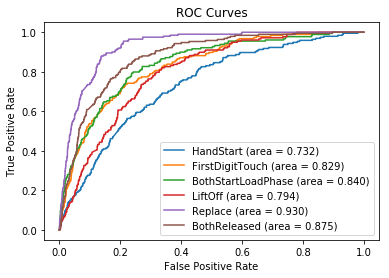

Test subject 10, class HandStart
Test subject 10, class FirstDigitTouch
Test subject 10, class BothStartLoadPhase
Test subject 10, class LiftOff
Test subject 10, class Replace
Test subject 10, class BothReleased
HandStart AUC score = 0.728
FirstDigitTouch AUC score = 0.916
BothStartLoadPhase AUC score = 0.901
LiftOff AUC score = 0.825
Replace AUC score = 0.867
BothReleased AUC score = 0.792


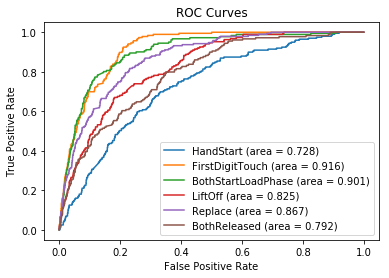

Test subject 11, class HandStart
Test subject 11, class FirstDigitTouch
Test subject 11, class BothStartLoadPhase
Test subject 11, class LiftOff
Test subject 11, class Replace
Test subject 11, class BothReleased
HandStart AUC score = 0.671
FirstDigitTouch AUC score = 0.646
BothStartLoadPhase AUC score = 0.681
LiftOff AUC score = 0.690
Replace AUC score = 0.817
BothReleased AUC score = 0.804


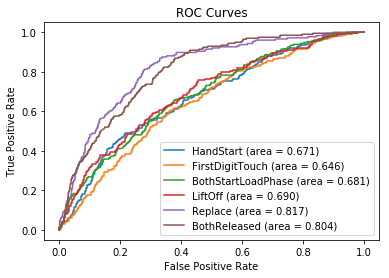

Test subject 12, class HandStart
Test subject 12, class FirstDigitTouch
Test subject 12, class BothStartLoadPhase
Test subject 12, class LiftOff
Test subject 12, class Replace
Test subject 12, class BothReleased
HandStart AUC score = 0.536
FirstDigitTouch AUC score = 0.674
BothStartLoadPhase AUC score = 0.640
LiftOff AUC score = 0.702
Replace AUC score = 0.787
BothReleased AUC score = 0.737


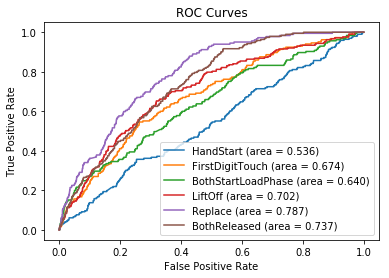

In [20]:


for subject in TEST_SUBJECTS:
    prediction_total = []
    test_data_total = []
    test_features_raw = []
    train_data_paths = glob(TRAIN_DATA_PATH % (subject))

    
    x_raw, y_raw = read_training_data(train_data_paths)
    
    x_raw, _ = preprocess_data(x_raw, WINDOW_SIZE, SUBSAMPLE)

    _, x_test, _, y_test = train_test_split(x_raw, y_raw[::SUBSAMPLE], test_size=0.5)

    
    for i in range(N_LABELS):

        test_labels = to_categorical(y_test[:,i], num_classes = None)
                
        print('Test subject %d, class %s' % (subject, COLUMNS[i]))                
        predictions = predict_on_sub(x_test, models[i], SPLIT_SIZE, BATCH_SIZE)
        
        test_data_total.append(y_test[:,i][1000::BATCH_SIZE])
        prediction_total.append(predictions)
        
    multiple_metric_auc_score(prediction_total, test_data_total, True)